<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/floatError_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

In [94]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [95]:
n_mels = 160
fs = 62500
frame_length_ms=80
frame_shift_ms=40
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'



with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [96]:
print(nsc)
print(nov)
print(nhop)

5000
2500
2500


In [0]:
# 여기서 테스트 시간 줄이는 걸 할 겁니다.
# 데이터 20개만 보는 걸로
# metadata = metadata[:100, :]

In [0]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [100]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [103]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/test', npy_name)
    mel_path_list.append(mel_path)
    
    # If you have already saved mel-spectrogram, skip mel creating process
    if not os.path.isfile(mel_path):
        
        y, sr = librosa.core.load(wav_path, sr=fs) # I made a mistake... sr=fs 죄송... 이거 넣어야 반영이 되는데, 실수로 안 넣음... fs=22050으로 강제 변환 되고 있음 ㅠㅜ
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
#       Sxx = np.maximum(Sxx, eps)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

        np.save(mel_path, norm_log_mel_specgram)

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # print('Input Tensor Shape: {}'.format(input_tensor.shape))

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # print('Encoded Tensor Shape: {}'.format(encoded_tensor.shape))

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)

        # print('Prediction Tensor Shape: {}'.format(pred_tensor.shape))
        # print(pred_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # print("Target Lengths: {}".format(target_lengths))

        for i in range(target_lengths.shape[0]):
            if target_lengths[i] > pred_tensor.shape[0]:
                target_lengths[i] = pred_tensor.shape[0]

        # print("Target Lengths: {}".format(target_lengths))

        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        # print("Loss: {}".format(loss))
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # print("Ground Truth Shape: {}".format(ground_truth.shape))
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
              
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        for i in range(target_lengths.shape[0]):
            if target_lengths[i] > pred_tensor.shape[0]:
                target_lengths[i] = pred_tensor.shape[0]

        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(160, 1024, 512)

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    # Load the spectrogram image from the disk
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
    
    # Check if tensor number i is already loaded, if not load and returns the image
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    # Try loading every images
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    # Get batch
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order].float()
        
            pad_random = np.random.randint(0, 5)
            
            # Time shift, add zeros in front of an image
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2]).float()
                target = torch.cat((offset, target), 1).float()
            
            # Add random noise
#             target = target + (torch.rand(target.shape, dtype=torch.double) - 0.5) / 20
            target = target.float() + (torch.rand(target.shape) - 0.5) / 20
        
            # Value less than 0 or more than 1 is clamped to 0 and 1
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target.float()
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order]).float()
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order]).float()
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [108]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

12833
12833
10266
10266
2567


In [110]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 64)
preloader_eval.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 64)
preloader_train.initialize_preloader()

In [0]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'float_error_debug'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

# try:
#     loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
#     loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
# except:
#     print("Loading Failed")

09-13 04:49:15
Mean Train Loss: 0.08349524713955626
Mean Evaluation Loss: 0.08345297773382328
-------------------------------------------------------------------------------------------------------
09-13 04:49:36
Mean Train Loss: 0.07965825421419143
Mean Evaluation Loss: 0.08220549862491495
-------------------------------------------------------------------------------------------------------
09-13 04:49:58
Mean Train Loss: 0.07940195470649575
Mean Evaluation Loss: 0.0826343610141125
-------------------------------------------------------------------------------------------------------
09-13 04:50:19
Mean Train Loss: 0.0796123234206957
Mean Evaluation Loss: 0.08380219196318264
-------------------------------------------------------------------------------------------------------
09-13 04:50:41
Mean Train Loss: 0.07880168429532741
Mean Evaluation Loss: 0.08111076705584216
-------------------------------------------------------------------------------------------------------
09-13 04:51:

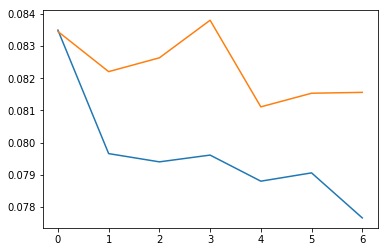

이느                                                                          ᄋᄋᄋᆻ아.<eos>
이느 ᄋᆻ아.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


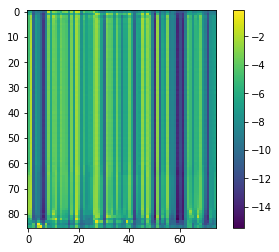

이느                                                             ᄋᄋᄋᆻ아.<eos>
이느 ᄋᆻ아.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


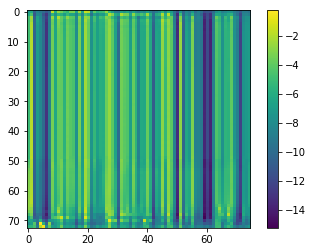

-------------------------------------------------------------------------------------------------------
09-13 04:51:46
Mean Train Loss: 0.0795369475109005
Mean Evaluation Loss: 0.08123750127154412
-------------------------------------------------------------------------------------------------------
09-13 04:52:08
Mean Train Loss: 0.0791046178986895
Mean Evaluation Loss: 0.08162081074459254
-------------------------------------------------------------------------------------------------------
09-13 04:52:29
Mean Train Loss: 0.07923007411261311
Mean Evaluation Loss: 0.08087079626803656
-------------------------------------------------------------------------------------------------------
09-13 04:52:50
Mean Train Loss: 0.07600072547013309
Mean Evaluation Loss: 0.08179991236009991
-------------------------------------------------------------------------------------------------------
09-13 04:53:12
Mean Train Loss: 0.08009447303476688
Mean Evaluation Loss: 0.08027868928336088
------------

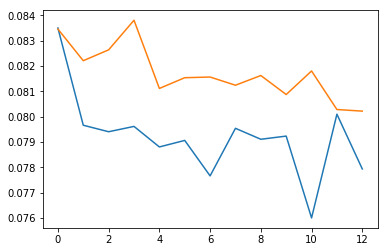

으 ᄋ                                                    알ᄋ      ------ᄋ이다.<eos>
으 ᄋ 알ᄋ 이다.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


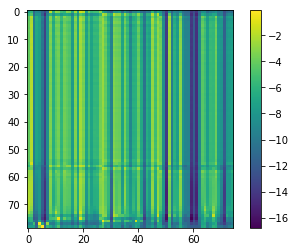

으                                             아           -----ᄋᄋ이다.<eos>
으 아 이다.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


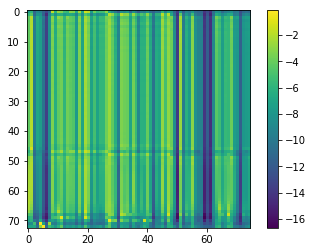

-------------------------------------------------------------------------------------------------------
09-13 04:53:55
Mean Train Loss: 0.07777950418522836
Mean Evaluation Loss: 0.07867538988941274
-------------------------------------------------------------------------------------------------------
09-13 04:54:17
Mean Train Loss: 0.07769039610164082
Mean Evaluation Loss: 0.08083430514471147
-------------------------------------------------------------------------------------------------------
09-13 04:54:38
Mean Train Loss: 0.07963358155969984
Mean Evaluation Loss: 0.08014588007277261
-------------------------------------------------------------------------------------------------------
09-13 04:54:59
Mean Train Loss: 0.07739558424536339
Mean Evaluation Loss: 0.07863303950607603
-------------------------------------------------------------------------------------------------------
09-13 04:55:21
Mean Train Loss: 0.07696776728536354
Mean Evaluation Loss: 0.08019319838866576
----------

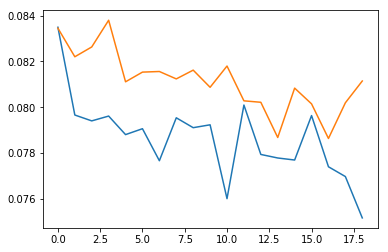

으 ᄋ                                                      가                   ᆸ이다.<eos>
으 ᄋ 가 ᆸ이다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


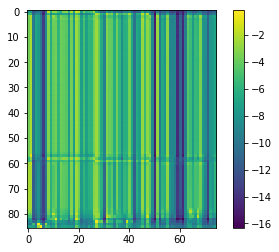

으느ᅳ                                              그             ᆸ이다.<eos>
으느 그 ᆸ이다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


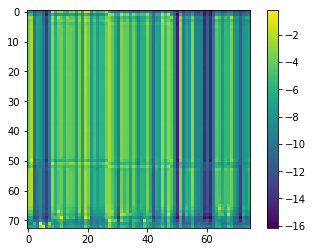

-------------------------------------------------------------------------------------------------------
09-13 04:56:04
Mean Train Loss: 0.07595841644965955
Mean Evaluation Loss: 0.07899249783465034
-------------------------------------------------------------------------------------------------------
09-13 04:56:25
Mean Train Loss: 0.07684171217183215
Mean Evaluation Loss: 0.07935906585610897
-------------------------------------------------------------------------------------------------------
09-13 04:56:46
Mean Train Loss: 0.07667807879720479
Mean Evaluation Loss: 0.07811209152048977
-------------------------------------------------------------------------------------------------------
09-13 04:57:08
Mean Train Loss: 0.07540683123250497
Mean Evaluation Loss: 0.07694421239217207
-------------------------------------------------------------------------------------------------------
09-13 04:57:30
Mean Train Loss: 0.07376406851137705
Mean Evaluation Loss: 0.07989548018847148
----------

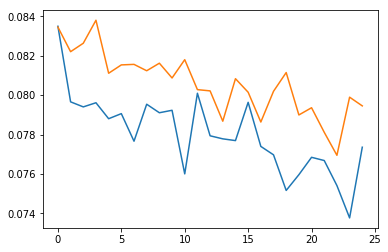

아 ᅡ                                                   ᅡᅡ      -- ---- --- ----ᄋ니다.<eos>
아 ᅡ ᅡ    ᄋ니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


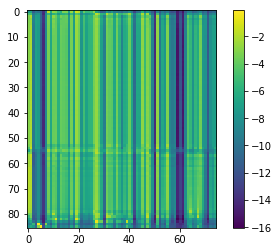

아 ᅡᄋᄋ                                                 ᅡᅡ         ᆸ니다.<eos>
아 ᅡᄋ ᅡ ᆸ니다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


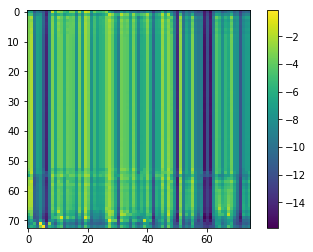

-------------------------------------------------------------------------------------------------------
09-13 04:58:13
Mean Train Loss: 0.07625800114006215
Mean Evaluation Loss: 0.07874198384313671
-------------------------------------------------------------------------------------------------------
09-13 04:58:34
Mean Train Loss: 0.0768778300144159
Mean Evaluation Loss: 0.07902709952415653
-------------------------------------------------------------------------------------------------------
09-13 04:58:56
Mean Train Loss: 0.07668984983910479
Mean Evaluation Loss: 0.07825480130217952
-------------------------------------------------------------------------------------------------------
09-13 04:59:18
Mean Train Loss: 0.07746324760206359
Mean Evaluation Loss: 0.0807692992487117
-------------------------------------------------------------------------------------------------------
09-13 04:59:39
Mean Train Loss: 0.07973036727609076
Mean Evaluation Loss: 0.08045585100884978
------------

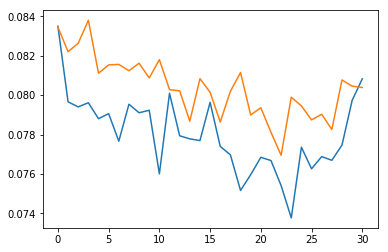

아                                                                          ᄋᄋᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


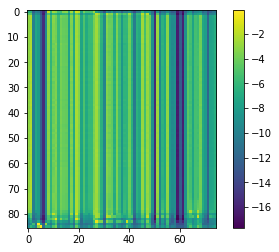

아                                                            ᄋᄋᄋᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


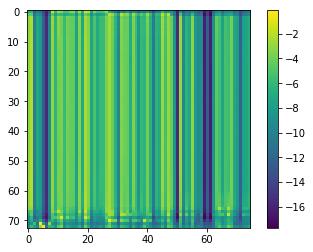

-------------------------------------------------------------------------------------------------------
09-13 05:00:22
Mean Train Loss: 0.08010879260083788
Mean Evaluation Loss: 0.08029748744299502
-------------------------------------------------------------------------------------------------------
09-13 05:00:44
Mean Train Loss: 0.08096776545485414
Mean Evaluation Loss: 0.08026773557956178
-------------------------------------------------------------------------------------------------------
09-13 05:01:05
Mean Train Loss: 0.07879893739835117
Mean Evaluation Loss: 0.07901810179368864
-------------------------------------------------------------------------------------------------------
09-13 05:01:26
Mean Train Loss: 0.07817377155370517
Mean Evaluation Loss: 0.07994346027368184
-------------------------------------------------------------------------------------------------------
09-13 05:01:47
Mean Train Loss: 0.07839018677844269
Mean Evaluation Loss: 0.07954885713855488
----------

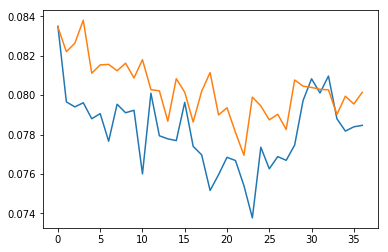

아                                                                            ᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


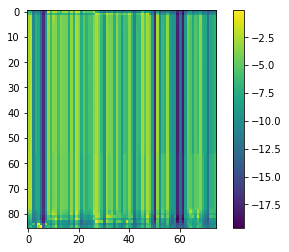

아                                                               ᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


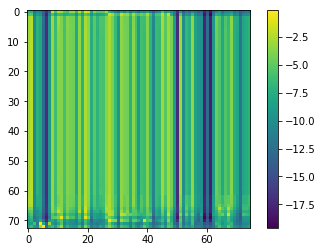

-------------------------------------------------------------------------------------------------------
09-13 05:02:30
Mean Train Loss: 0.07877125931470996
Mean Evaluation Loss: 0.08008453892434904
-------------------------------------------------------------------------------------------------------
09-13 05:02:51
Mean Train Loss: 0.07929938363996578
Mean Evaluation Loss: 0.07977443760463794
-------------------------------------------------------------------------------------------------------
09-13 05:03:13
Mean Train Loss: 0.07826550994499609
Mean Evaluation Loss: 0.07942029441056617
-------------------------------------------------------------------------------------------------------
09-13 05:03:34
Mean Train Loss: 0.07822422533240996
Mean Evaluation Loss: 0.07885676013638433
-------------------------------------------------------------------------------------------------------
09-13 05:03:55
Mean Train Loss: 0.0776524541043348
Mean Evaluation Loss: 0.07915035923889034
-----------

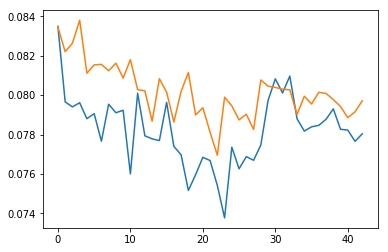

아느                                                                   -ᆸᄋᆻ다.<eos>
아느 ᆸᄋᆻ다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


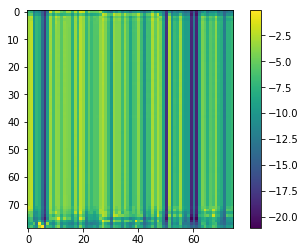

아느                                                            --ᆸᄋᆻ다.<eos>
아느 ᆸᄋᆻ다.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


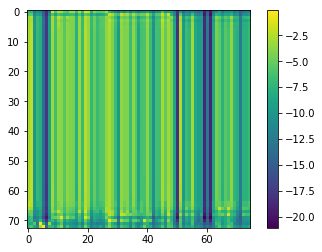

-------------------------------------------------------------------------------------------------------
09-13 05:04:38
Mean Train Loss: 0.07826575285243312
Mean Evaluation Loss: 0.07940789955142925
-------------------------------------------------------------------------------------------------------
09-13 05:05:00
Mean Train Loss: 0.07780295013752869
Mean Evaluation Loss: 0.07877932169430069
-------------------------------------------------------------------------------------------------------
09-13 05:05:21
Mean Train Loss: 0.07814569121566557
Mean Evaluation Loss: 0.0796783282573516
-------------------------------------------------------------------------------------------------------
09-13 05:05:42
Mean Train Loss: 0.079199288417394
Mean Evaluation Loss: 0.0796412008133591
-------------------------------------------------------------------------------------------------------
09-13 05:06:04
Mean Train Loss: 0.07786665262640516
Mean Evaluation Loss: 0.07957533122850956
--------------

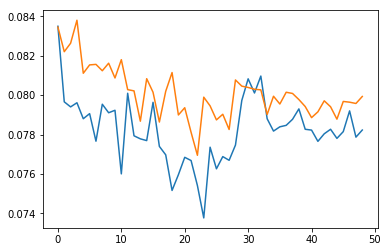

아느                                                         -------------------ᄋᆻ다.<eos>
아느 ᄋᆻ다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


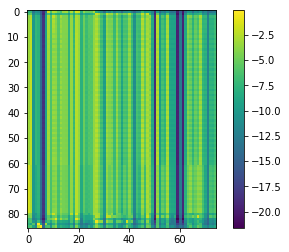

아느                                              -----------------ᄋᆻ다.<eos>
아느 ᄋᆻ다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


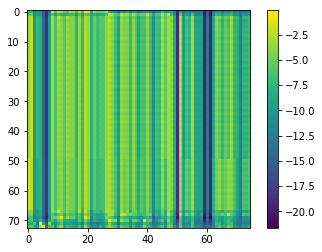

-------------------------------------------------------------------------------------------------------
09-13 05:06:47
Mean Train Loss: 0.07807030548881337
Mean Evaluation Loss: 0.08352606958578469
-------------------------------------------------------------------------------------------------------
09-13 05:07:08
Mean Train Loss: 0.07793703926716931
Mean Evaluation Loss: 0.08166664226577902
-------------------------------------------------------------------------------------------------------
09-13 05:07:29
Mean Train Loss: 0.08167015078362366
Mean Evaluation Loss: 0.08025848612404037
-------------------------------------------------------------------------------------------------------
09-13 05:07:50
Mean Train Loss: 0.0785825860456806
Mean Evaluation Loss: 0.07970443858140237
-------------------------------------------------------------------------------------------------------
09-13 05:08:11
Mean Train Loss: 0.07864744629950476
Mean Evaluation Loss: 0.07972733335086797
-----------

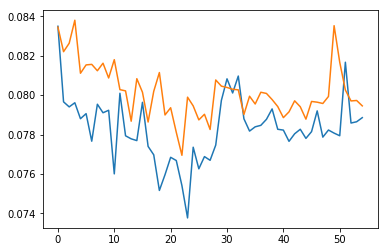

아                                                          --------------------ᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


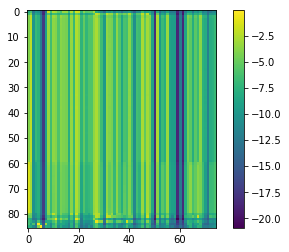

아                                                    -------------ᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


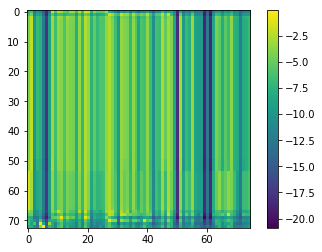

-------------------------------------------------------------------------------------------------------
09-13 05:08:54
Mean Train Loss: 0.07879274125403549
Mean Evaluation Loss: 0.07934764745750751
-------------------------------------------------------------------------------------------------------
09-13 05:09:15
Mean Train Loss: 0.0782388490382461
Mean Evaluation Loss: 0.07915805313585009
-------------------------------------------------------------------------------------------------------
09-13 05:09:36
Mean Train Loss: 0.07808818591777268
Mean Evaluation Loss: 0.079893729199615
-------------------------------------------------------------------------------------------------------
09-13 05:09:57
Mean Train Loss: 0.07839562436256588
Mean Evaluation Loss: 0.07882478375065148
-------------------------------------------------------------------------------------------------------
09-13 05:10:19
Mean Train Loss: 0.07773915883924434
Mean Evaluation Loss: 0.07871670284812318
-------------

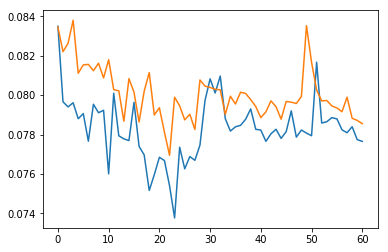

아ᄂ                                                               --------------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


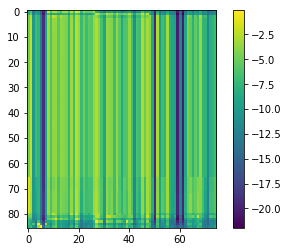

아ᄂ                                                      ----------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


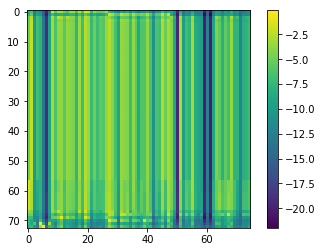

-------------------------------------------------------------------------------------------------------
09-13 05:11:02
Mean Train Loss: 0.07770236156224485
Mean Evaluation Loss: 0.0782888298351628
-------------------------------------------------------------------------------------------------------
09-13 05:11:24
Mean Train Loss: 0.0776564183776298
Mean Evaluation Loss: 0.07933799168494783
-------------------------------------------------------------------------------------------------------
09-13 05:11:45
Mean Train Loss: 0.07812265706853577
Mean Evaluation Loss: 0.07870231266851653
-------------------------------------------------------------------------------------------------------
09-13 05:12:06
Mean Train Loss: 0.07783404753960624
Mean Evaluation Loss: 0.07899438339912276
-------------------------------------------------------------------------------------------------------
09-13 05:12:28
Mean Train Loss: 0.07799162613535601
Mean Evaluation Loss: 0.07957069381525658
------------

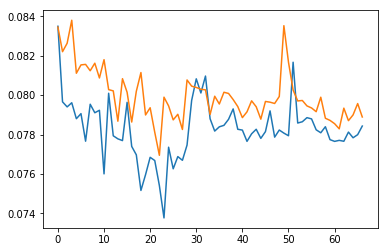

아ᄂ                                                       ----------------------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


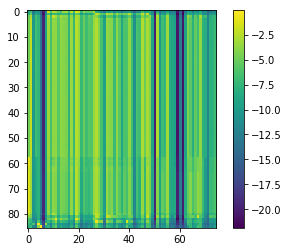

아ᄂ                                                      ----------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


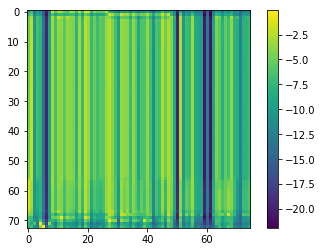

-------------------------------------------------------------------------------------------------------
09-13 05:13:11
Mean Train Loss: 0.07794167977113854
Mean Evaluation Loss: 0.07886225986985312
-------------------------------------------------------------------------------------------------------
09-13 05:13:32
Mean Train Loss: 0.07791683115433846
Mean Evaluation Loss: 0.07886279091333878
-------------------------------------------------------------------------------------------------------
09-13 05:13:53
Mean Train Loss: 0.07786187217459199
Mean Evaluation Loss: 0.07969979569537036
-------------------------------------------------------------------------------------------------------
09-13 05:14:14
Mean Train Loss: 0.07846602892416087
Mean Evaluation Loss: 0.07932002224962877
-------------------------------------------------------------------------------------------------------
09-13 05:14:35
Mean Train Loss: 0.07814144391775213
Mean Evaluation Loss: 0.07885468067160091
----------

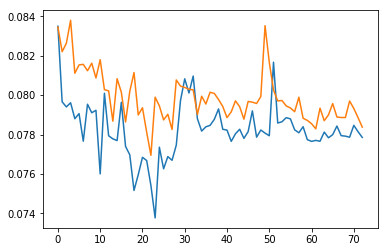

아느                                                               ------ᄋᆻ다.<eos>
아느 ᄋᆻ다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


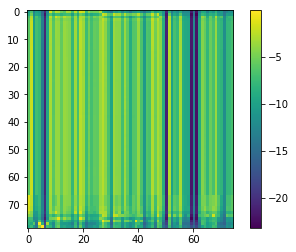

아느                                             ------------------ᄋᆻ다.<eos>
아느 ᄋᆻ다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


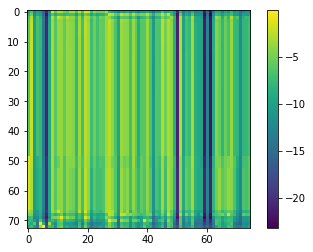

-------------------------------------------------------------------------------------------------------
09-13 05:15:18
Mean Train Loss: 0.07786222050520882
Mean Evaluation Loss: 0.07900367372963493
-------------------------------------------------------------------------------------------------------
09-13 05:15:39
Mean Train Loss: 0.07798443795549354
Mean Evaluation Loss: 0.07843257601199834
-------------------------------------------------------------------------------------------------------
09-13 05:16:00
Mean Train Loss: 0.07763537659086182
Mean Evaluation Loss: 0.07876804898614283
-------------------------------------------------------------------------------------------------------
09-13 05:16:22
Mean Train Loss: 0.07801027619098094
Mean Evaluation Loss: 0.07912704550605876
-------------------------------------------------------------------------------------------------------
09-13 05:16:43
Mean Train Loss: 0.07801596103469294
Mean Evaluation Loss: 0.0786432538184903
-----------

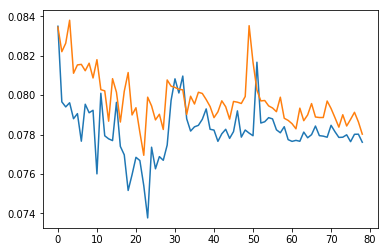

아 ᅳᅡ ᅡ  ᅡ  ᅡ 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 ----------------------ᆻ아.<eos>
아 ᅳᅡ ᅡ ᅡ ᅡ 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 ᆻ아.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


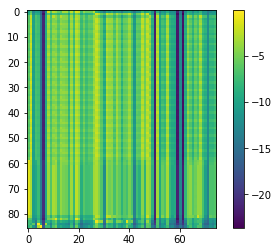

아ᄂ아 ᅳᅡ ᅡ  ᅡ  ᅡ  ᅡ 아 아 아 아 아 아 아 아 아----------------------ᆻ아.<eos>
아ᄂ아 ᅳᅡ ᅡ ᅡ ᅡ ᅡ 아 아 아 아 아 아 아 아 았아.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


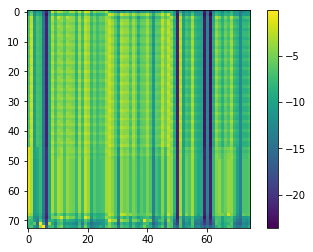

-------------------------------------------------------------------------------------------------------
09-13 05:17:27
Mean Train Loss: 0.07643366562099346
Mean Evaluation Loss: 0.07835482462597079
-------------------------------------------------------------------------------------------------------
09-13 05:17:48
Mean Train Loss: 0.07802254507379555
Mean Evaluation Loss: 0.07905703188413546
-------------------------------------------------------------------------------------------------------
09-13 05:18:10
Mean Train Loss: 0.07782771741490307
Mean Evaluation Loss: 0.07913185654364861
-------------------------------------------------------------------------------------------------------
09-13 05:18:31
Mean Train Loss: 0.07800340751529576
Mean Evaluation Loss: 0.07898920195556519
-------------------------------------------------------------------------------------------------------
09-13 05:18:52
Mean Train Loss: 0.07797506958739617
Mean Evaluation Loss: 0.08019135378476065
----------

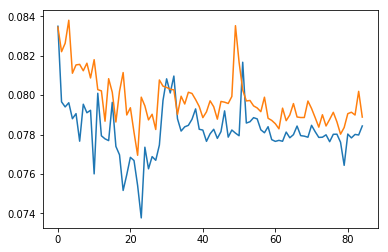

은ᅳ ᅳ                                                                         -이다.<eos>
은ᅳ ᅳ 이다.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


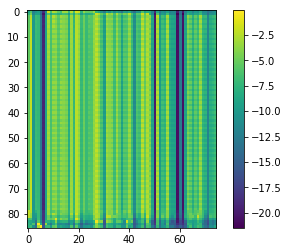

은ᅳᆫᅳ                                              ----------------ᆻ다.<eos>
은ᅳᆫᅳ ᆻ다.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


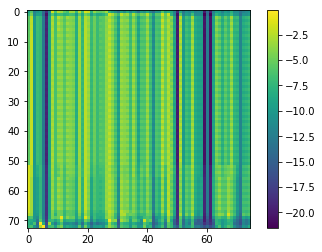

-------------------------------------------------------------------------------------------------------
09-13 05:19:35
Mean Train Loss: 0.07815551142480293
Mean Evaluation Loss: 0.07951466893998976
-------------------------------------------------------------------------------------------------------
09-13 05:19:56
Mean Train Loss: 0.07816211387121928
Mean Evaluation Loss: 0.07893538120791803
-------------------------------------------------------------------------------------------------------
09-13 05:20:17
Mean Train Loss: 0.0783692645855553
Mean Evaluation Loss: 0.07907301114330524
-------------------------------------------------------------------------------------------------------
09-13 05:20:38
Mean Train Loss: 0.07823249166832108
Mean Evaluation Loss: 0.080006534479149
-------------------------------------------------------------------------------------------------------
09-13 05:20:59
Mean Train Loss: 0.07866703131406655
Mean Evaluation Loss: 0.07972433527875722
-------------

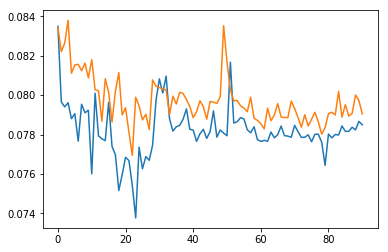

아                                                         ----------------------ᆻ다.<eos>
아 ᆻ다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


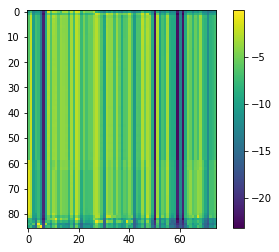

아                                                ------------------ᆻ다.<eos>
아 ᆻ다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


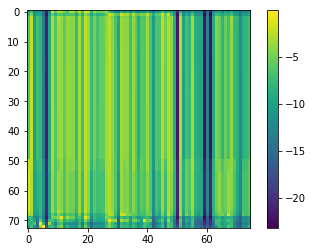

-------------------------------------------------------------------------------------------------------
09-13 05:21:43
Mean Train Loss: 0.07823128450797749
Mean Evaluation Loss: 0.07925754185271007
-------------------------------------------------------------------------------------------------------
09-13 05:22:04
Mean Train Loss: 0.0784008210273515
Mean Evaluation Loss: 0.07959634662849083
-------------------------------------------------------------------------------------------------------
09-13 05:22:25
Mean Train Loss: 0.07878048151435735
Mean Evaluation Loss: 0.07970681435717027
-------------------------------------------------------------------------------------------------------
09-13 05:22:46
Mean Train Loss: 0.0780763330508336
Mean Evaluation Loss: 0.07914502809991485
-------------------------------------------------------------------------------------------------------
09-13 05:23:07
Mean Train Loss: 0.07811151178421122
Mean Evaluation Loss: 0.07907787594006327
------------

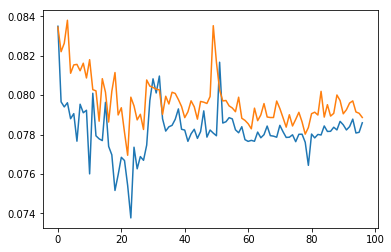

아ᄋ ᆫ ᆫ ᄋ ᆫ   ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ   ᄋ     ᄋ   ᄋ ᄋ ᄋ         ᄋ   ᄋ     ᄋ---------------이다.<eos>
아ᄋ ᆫ ᆫ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ이다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


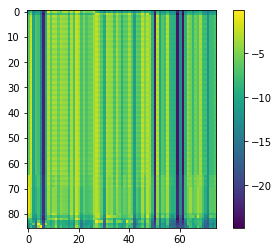

아ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ  --------이다.<eos>
아ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ 이다.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


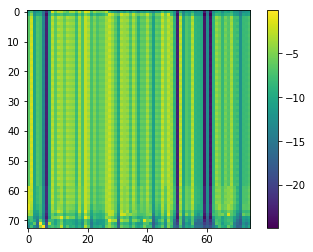

-------------------------------------------------------------------------------------------------------
09-13 05:23:50
Mean Train Loss: 0.0775985100209752
Mean Evaluation Loss: 0.07881641117196991
-------------------------------------------------------------------------------------------------------
09-13 05:24:11
Mean Train Loss: 0.07795791137099789
Mean Evaluation Loss: 0.0787904348619389
-------------------------------------------------------------------------------------------------------
09-13 05:24:32
Mean Train Loss: 0.07824153032488675
Mean Evaluation Loss: 0.07948788502478918
-------------------------------------------------------------------------------------------------------
09-13 05:24:53
Mean Train Loss: 0.07825359860336517
Mean Evaluation Loss: 0.07853651937482661
-------------------------------------------------------------------------------------------------------
09-13 05:25:14
Mean Train Loss: 0.0779193897178118
Mean Evaluation Loss: 0.07921948318179531
-------------

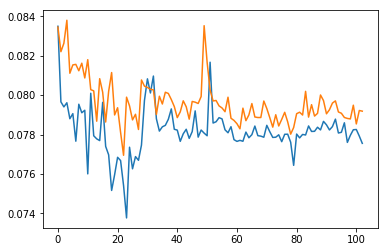

은 ᆫ                                                      ----------------------ᅵ다.<eos>
은 ᆫ ᅵ다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


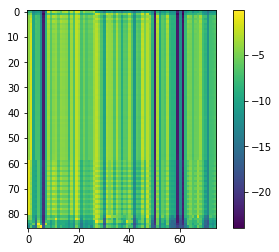

은                                                         --------ᅵ다.<eos>
은 ᅵ다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


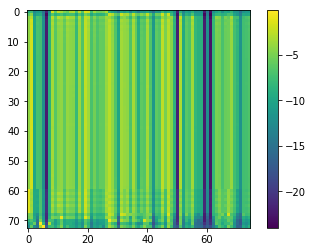

-------------------------------------------------------------------------------------------------------
09-13 05:25:57
Mean Train Loss: 0.07802851360433417
Mean Evaluation Loss: 0.07993113132606051
-------------------------------------------------------------------------------------------------------
09-13 05:26:19
Mean Train Loss: 0.07793415660179252
Mean Evaluation Loss: 0.07913339760532684
-------------------------------------------------------------------------------------------------------
09-13 05:26:40
Mean Train Loss: 0.07763190315210876
Mean Evaluation Loss: 0.07899714241886449
-------------------------------------------------------------------------------------------------------
09-13 05:27:01
Mean Train Loss: 0.07692588811424897
Mean Evaluation Loss: 0.07885588753573251
-------------------------------------------------------------------------------------------------------
09-13 05:27:23
Mean Train Loss: 0.0774466101185711
Mean Evaluation Loss: 0.07919420705841221
-----------

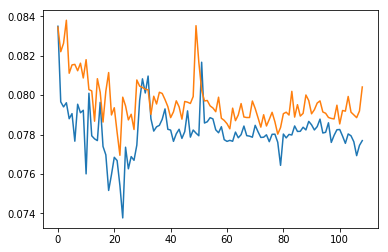

안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ----------았다.<eos>
안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ 았다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


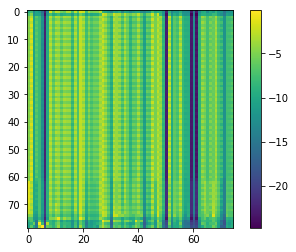

안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ------------ᄋ-ᄋᄋᆻ다.<eos>
안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋᄋᆻ다.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


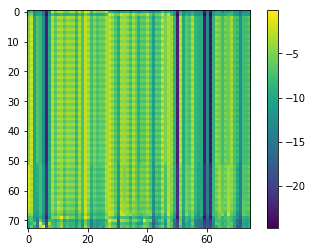

-------------------------------------------------------------------------------------------------------
09-13 05:28:06
Mean Train Loss: 0.07810278187983312
Mean Evaluation Loss: 0.07903868841021032
-------------------------------------------------------------------------------------------------------
09-13 05:28:27
Mean Train Loss: 0.07733748323419089
Mean Evaluation Loss: 0.0792709164259289
-------------------------------------------------------------------------------------------------------
09-13 05:28:48
Mean Train Loss: 0.07737526028930984
Mean Evaluation Loss: 0.0795979342511988
-------------------------------------------------------------------------------------------------------
09-13 05:29:09
Mean Train Loss: 0.07789966720597431
Mean Evaluation Loss: 0.07935476300609093
-------------------------------------------------------------------------------------------------------
09-13 05:29:30
Mean Train Loss: 0.0792332343849435
Mean Evaluation Loss: 0.07905727115801414
-------------

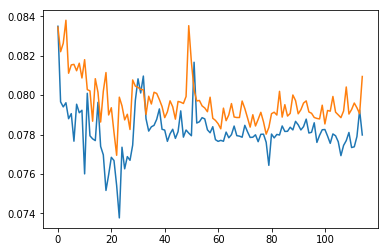

안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ-----------ᄋ-ᆻ다.<eos>
안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫᄋᆻ다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


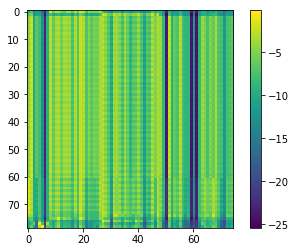

안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ-----ᄋ-ᆻ아.<eos>
안 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫᄋᆻ아.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


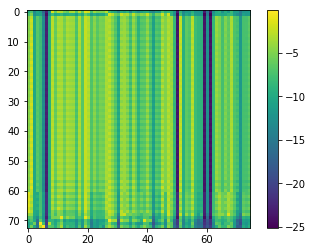

-------------------------------------------------------------------------------------------------------
09-13 05:30:13
Mean Train Loss: 0.07819626176793829
Mean Evaluation Loss: 0.07975420095239383
-------------------------------------------------------------------------------------------------------
09-13 05:30:34
Mean Train Loss: 0.07767737167150426
Mean Evaluation Loss: 0.07898099914838984
-------------------------------------------------------------------------------------------------------
09-13 05:30:55
Mean Train Loss: 0.07729993765803188
Mean Evaluation Loss: 0.07880743553197041
-------------------------------------------------------------------------------------------------------
09-13 05:31:16
Mean Train Loss: 0.07747793985255305
Mean Evaluation Loss: 0.07877189012209294
-------------------------------------------------------------------------------------------------------
09-13 05:31:37
Mean Train Loss: 0.07722809766453617
Mean Evaluation Loss: 0.07976641420215431
----------

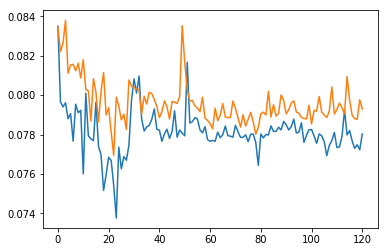

은 ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ     ᆫ ᆫᅡ-------------ᆻ다.<eos>
은 ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᆫ ᆫᅡᆻ다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


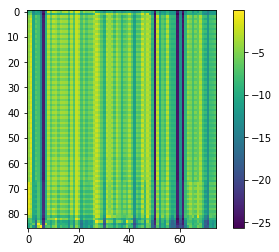

은 ᆫ                                                         ----ᄋ-ᆻ다.<eos>
은 ᆫ ᄋᆻ다.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


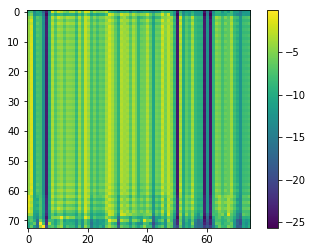

-------------------------------------------------------------------------------------------------------
09-13 05:32:20
Mean Train Loss: 0.07867729083515794
Mean Evaluation Loss: 0.0793410853046466
-------------------------------------------------------------------------------------------------------
09-13 05:32:41
Mean Train Loss: 0.07835131806180214
Mean Evaluation Loss: 0.07933878925836813
-------------------------------------------------------------------------------------------------------
09-13 05:33:03
Mean Train Loss: 0.07832559244235501
Mean Evaluation Loss: 0.07915958160409504
-------------------------------------------------------------------------------------------------------
09-13 05:33:24
Mean Train Loss: 0.0785270660353672
Mean Evaluation Loss: 0.07954967347135554
-------------------------------------------------------------------------------------------------------
09-13 05:33:46
Mean Train Loss: 0.07842806200107129
Mean Evaluation Loss: 0.07901799142838148
------------

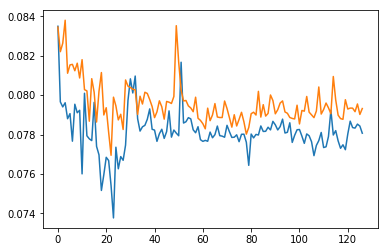

으ᄂ                                                           -----------ᄋᆻ다.<eos>
으ᄂ ᄋᆻ다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


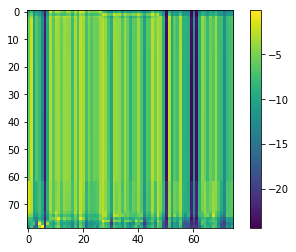

으ᄂ                                               -----------------ᄋᆻ다.<eos>
으ᄂ ᄋᆻ다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


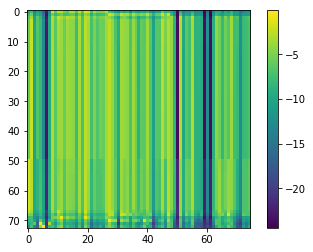

-------------------------------------------------------------------------------------------------------
09-13 05:34:28
Mean Train Loss: 0.07819634816974577
Mean Evaluation Loss: 0.07912569608384115
-------------------------------------------------------------------------------------------------------
09-13 05:34:50
Mean Train Loss: 0.0783397454475709
Mean Evaluation Loss: 0.07868873708493551
-------------------------------------------------------------------------------------------------------
09-13 05:35:11
Mean Train Loss: 0.07748863291059409
Mean Evaluation Loss: 0.07878679289682394
-------------------------------------------------------------------------------------------------------
09-13 05:35:32
Mean Train Loss: 0.07810841425512499
Mean Evaluation Loss: 0.07935642284880669
-------------------------------------------------------------------------------------------------------
09-13 05:35:53
Mean Train Loss: 0.0781701990702173
Mean Evaluation Loss: 0.07923874960132123
------------

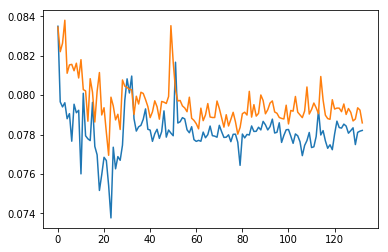

이                                                        ---------------------ᄋ이다.<eos>
이 이다.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


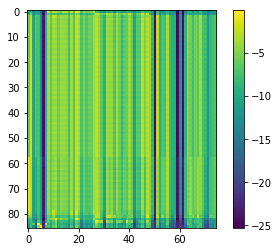

아                                                    ------------ᄋ이다.<eos>
아 이다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


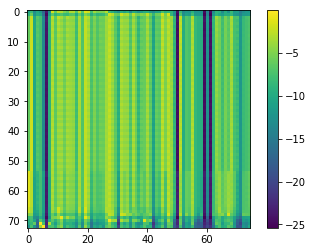

-------------------------------------------------------------------------------------------------------
09-13 05:36:37
Mean Train Loss: 0.07817467892472926
Mean Evaluation Loss: 0.07834377492838558
-------------------------------------------------------------------------------------------------------
09-13 05:36:58
Mean Train Loss: 0.07799052097280194
Mean Evaluation Loss: 0.07875950689001655
-------------------------------------------------------------------------------------------------------
09-13 05:37:19
Mean Train Loss: 0.07798736924172742
Mean Evaluation Loss: 0.07845332797898193
-------------------------------------------------------------------------------------------------------
09-13 05:37:40
Mean Train Loss: 0.07836224224011497
Mean Evaluation Loss: 0.0809586151354921
-------------------------------------------------------------------------------------------------------
09-13 05:38:01
Mean Train Loss: 0.07900566747255301
Mean Evaluation Loss: 0.07926896501433496
-----------

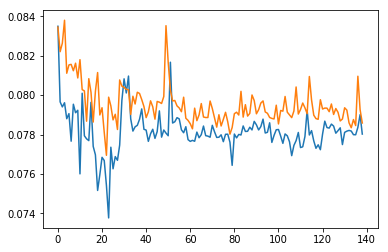

은 ᆫ     ᆫ ᆫ ᆫ                                            --------------ᄋᆻ다.<eos>
은 ᆫ ᆫ ᆫ ᆫ ᄋᆻ다.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


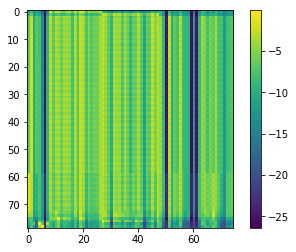

으ᄂ                                          ----------------------ᄋᆻ다.<eos>
으ᄂ ᄋᆻ다.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


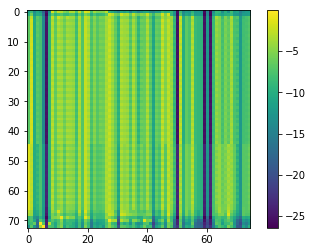

-------------------------------------------------------------------------------------------------------
09-13 05:38:44
Mean Train Loss: 0.07799465271310888
Mean Evaluation Loss: 0.0805387928375762
-------------------------------------------------------------------------------------------------------
09-13 05:39:05
Mean Train Loss: 0.07836027944952381
Mean Evaluation Loss: 0.07909073910718013
-------------------------------------------------------------------------------------------------------
09-13 05:39:26
Mean Train Loss: 0.07760557976143559
Mean Evaluation Loss: 0.07851235591336651
-------------------------------------------------------------------------------------------------------
09-13 05:39:47
Mean Train Loss: 0.07758719329860346
Mean Evaluation Loss: 0.07829027370326212
-------------------------------------------------------------------------------------------------------
09-13 05:40:08
Mean Train Loss: 0.07751745805218259
Mean Evaluation Loss: 0.0797626165639278
------------

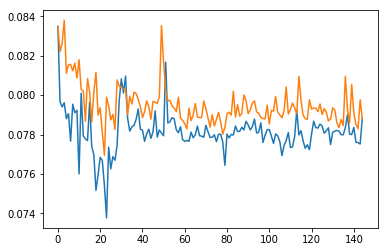

아ᄂ                                                  --------------------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


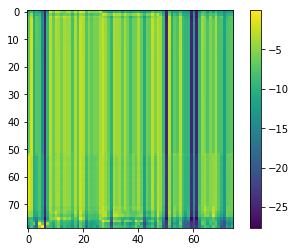

아ᄂ                                                ---------------ᄋᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


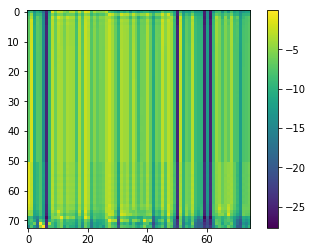

-------------------------------------------------------------------------------------------------------
09-13 05:40:51
Mean Train Loss: 0.07811214583879157
Mean Evaluation Loss: 0.07922363426954927
-------------------------------------------------------------------------------------------------------
09-13 05:41:12
Mean Train Loss: 0.07807194375713533
Mean Evaluation Loss: 0.07819611488579115
-------------------------------------------------------------------------------------------------------
09-13 05:41:33
Mean Train Loss: 0.07790786229433054
Mean Evaluation Loss: 0.07854444968385352
-------------------------------------------------------------------------------------------------------
09-13 05:41:54
Mean Train Loss: 0.0778470307945487
Mean Evaluation Loss: 0.0785841389677193
-------------------------------------------------------------------------------------------------------
09-13 05:42:16
Mean Train Loss: 0.07780322602115629
Mean Evaluation Loss: 0.07856740625111244
------------

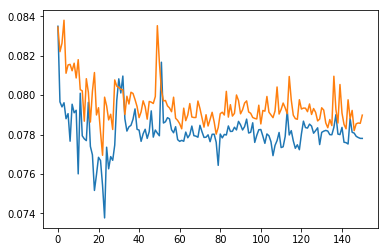

아ᄂ                                                       --------------ᆸᄋᆻ다.<eos>
아ᄂ ᆸᄋᆻ다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


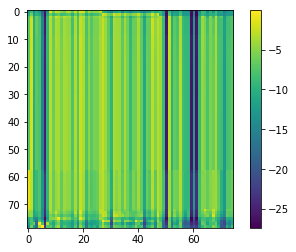

아ᄂ                                             ------------------ᆸᄋᆻ다.<eos>
아ᄂ ᆸᄋᆻ다.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


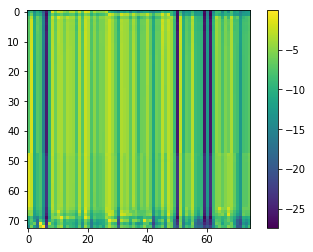

-------------------------------------------------------------------------------------------------------
09-13 05:42:59
Mean Train Loss: 0.07793174357238963
Mean Evaluation Loss: 0.07851578967241354
-------------------------------------------------------------------------------------------------------
09-13 05:43:20
Mean Train Loss: 0.07777056514122571
Mean Evaluation Loss: 0.07919792741483625
-------------------------------------------------------------------------------------------------------
09-13 05:43:41
Mean Train Loss: 0.0782028417634729
Mean Evaluation Loss: 0.07821315060210296
-------------------------------------------------------------------------------------------------------
09-13 05:44:03
Mean Train Loss: 0.07768623306040583
Mean Evaluation Loss: 0.07946960711722283
-------------------------------------------------------------------------------------------------------
09-13 05:44:24
Mean Train Loss: 0.07816817496299498
Mean Evaluation Loss: 0.0793047644572414
------------

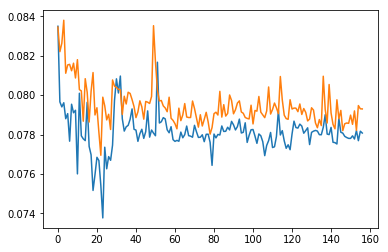

이느                                                                 ----------ᆸᄋᆻ다.<eos>
이느 ᆸᄋᆻ다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


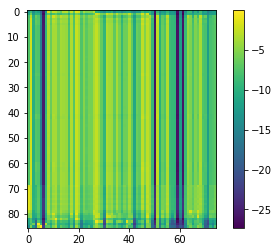

이는                                            ᄋ----------------ᆸ이다.<eos>
이는 ᄋᆸ이다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


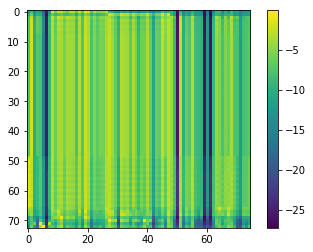

-------------------------------------------------------------------------------------------------------
09-13 05:45:07
Mean Train Loss: 0.07816521447749836
Mean Evaluation Loss: 0.07891915919583885
-------------------------------------------------------------------------------------------------------
09-13 05:45:28
Mean Train Loss: 0.07775957317861298
Mean Evaluation Loss: 0.07947540636183562
-------------------------------------------------------------------------------------------------------
09-13 05:45:50
Mean Train Loss: 0.07747763994928707
Mean Evaluation Loss: 0.07805704316368584
-------------------------------------------------------------------------------------------------------
09-13 05:46:11
Mean Train Loss: 0.07688985494837564
Mean Evaluation Loss: 0.07818323157918021
-------------------------------------------------------------------------------------------------------
09-13 05:46:32
Mean Train Loss: 0.07697010999931092
Mean Evaluation Loss: 0.07957233349252046
----------

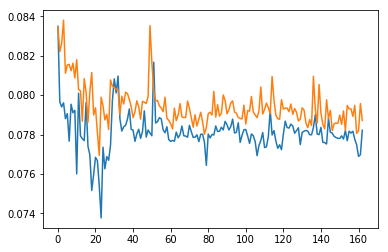

이ᄂ ᆫ                                                              ------------ᆸ이다.<eos>
이ᄂ ᆫ ᆸ이다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


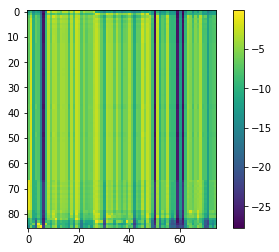

아ᄂ ᄋ                                             ----------------ᆸᄋᆻ아.<eos>
아ᄂ ᄋ ᆸᄋᆻ아.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


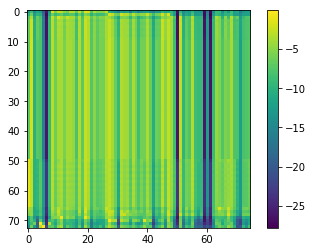

-------------------------------------------------------------------------------------------------------
09-13 05:47:15
Mean Train Loss: 0.07759369328668185
Mean Evaluation Loss: 0.07939983219186221
-------------------------------------------------------------------------------------------------------
09-13 05:47:36
Mean Train Loss: 0.07812203540951822
Mean Evaluation Loss: 0.07947460694740485
-------------------------------------------------------------------------------------------------------
09-13 05:47:57
Mean Train Loss: 0.07806496973657245
Mean Evaluation Loss: 0.07913681556608083
-------------------------------------------------------------------------------------------------------
09-13 05:48:18
Mean Train Loss: 0.07818252416557396
Mean Evaluation Loss: 0.07860958875454209
-------------------------------------------------------------------------------------------------------
09-13 05:48:39
Mean Train Loss: 0.0778893407484334
Mean Evaluation Loss: 0.07948727706131996
-----------

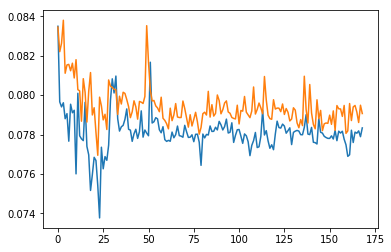

아ᄂ                                                       -------------ᅡᆸ이다.<eos>
아ᄂ ᅡᆸ이다.<eos>
해외로부터 전염병이 유입되어 확산되는 것을 방지하기 위한 노력이 있었다.<eos>-------------------


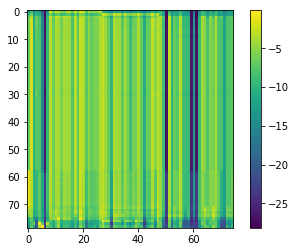

아ᄂ                                           -------------------ᅡᆸ이다.<eos>
아ᄂ ᅡᆸ이다.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


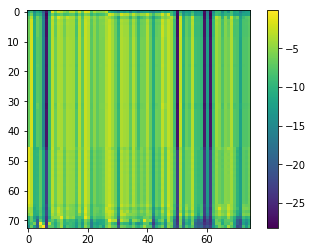

-------------------------------------------------------------------------------------------------------
09-13 05:49:22
Mean Train Loss: 0.07802597326639932
Mean Evaluation Loss: 0.07874420868629659
-------------------------------------------------------------------------------------------------------
09-13 05:49:43
Mean Train Loss: 0.07787605390986854
Mean Evaluation Loss: 0.07930957061746334
-------------------------------------------------------------------------------------------------------
09-13 05:50:04
Mean Train Loss: 0.07858895422894294
Mean Evaluation Loss: 0.07964700813684764
-------------------------------------------------------------------------------------------------------
09-13 05:50:25
Mean Train Loss: 0.07828620583107498
Mean Evaluation Loss: 0.07901616548705283
-------------------------------------------------------------------------------------------------------
09-13 05:50:46
Mean Train Loss: 0.07813766664941031
Mean Evaluation Loss: 0.07866114705309843
----------

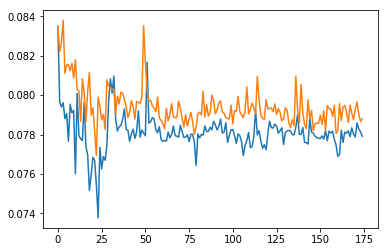

으는ᅳᆫ                                                         ᄋ-------ᆸᄋᆻ다.<eos>
으는ᅳᆫ ᄋᆸᄋᆻ다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


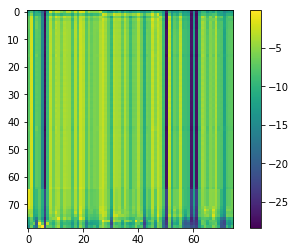

으는ᅳᆫ                                                -----------ᆸᄋᆻ다.<eos>
으는ᅳᆫ ᆸᄋᆻ다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


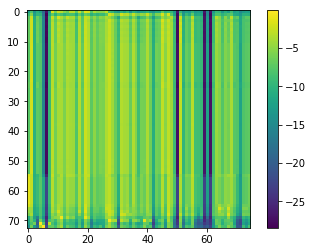

-------------------------------------------------------------------------------------------------------
09-13 05:51:30
Mean Train Loss: 0.07792549689564207
Mean Evaluation Loss: 0.079051808792764
-------------------------------------------------------------------------------------------------------
09-13 05:51:51
Mean Train Loss: 0.07789103231754635
Mean Evaluation Loss: 0.07914000260308755
-------------------------------------------------------------------------------------------------------
09-13 05:52:12
Mean Train Loss: 0.07815486686284014
Mean Evaluation Loss: 0.0786447334218501
-------------------------------------------------------------------------------------------------------
09-13 05:52:33
Mean Train Loss: 0.07763485953116124
Mean Evaluation Loss: 0.07832930075165484
-------------------------------------------------------------------------------------------------------
09-13 05:52:54
Mean Train Loss: 0.07761174209756443
Mean Evaluation Loss: 0.07895209109607065
-------------

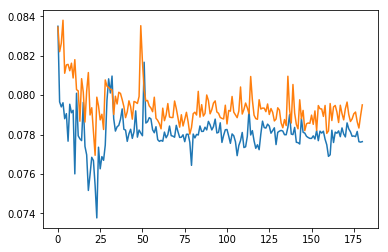

아는 ᄋ ᄋ   ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ------------ᄋᆸᄋᆻ다.<eos>
아는 ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋᆸᄋᆻ다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


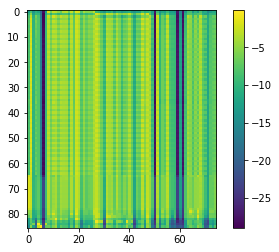

아는 ᆫ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ----------ᄋᆸᄋᆻ다.<eos>
아는 ᆫ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋᄋᆸᄋᆻ다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


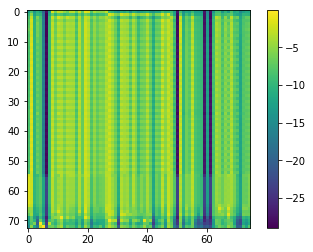

-------------------------------------------------------------------------------------------------------
09-13 05:53:38
Mean Train Loss: 0.07765904388780145
Mean Evaluation Loss: 0.07900260762511063
-------------------------------------------------------------------------------------------------------
09-13 05:53:59
Mean Train Loss: 0.07745246627504006
Mean Evaluation Loss: 0.07853583269667166
-------------------------------------------------------------------------------------------------------
09-13 05:54:20
Mean Train Loss: 0.0776375796685876
Mean Evaluation Loss: 0.07913167916388145
-------------------------------------------------------------------------------------------------------
09-13 05:54:41
Mean Train Loss: 0.07760378458713348
Mean Evaluation Loss: 0.07874395721958123
-------------------------------------------------------------------------------------------------------
09-13 05:55:02
Mean Train Loss: 0.07727333149303656
Mean Evaluation Loss: 0.07937427290106219
-----------

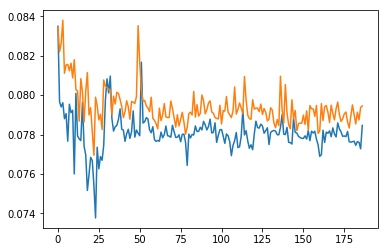

으는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ -------------------------ᄋ다.<eos>
으는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


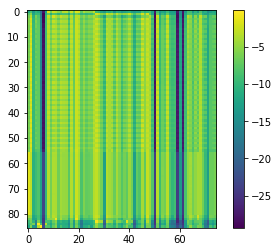

아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ-----------ᄋ다.<eos>
아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋᄋ다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


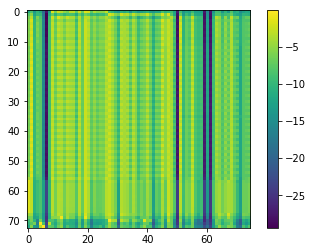

-------------------------------------------------------------------------------------------------------
09-13 05:55:45
Mean Train Loss: 0.07765529759947976
Mean Evaluation Loss: 0.079772082986518
-------------------------------------------------------------------------------------------------------
09-13 05:56:06
Mean Train Loss: 0.0774950325052967
Mean Evaluation Loss: 0.07853305744377757
-------------------------------------------------------------------------------------------------------
09-13 05:56:27
Mean Train Loss: 0.07722295741731064
Mean Evaluation Loss: 0.07897462235670093
-------------------------------------------------------------------------------------------------------
09-13 05:56:48
Mean Train Loss: 0.07831130521231944
Mean Evaluation Loss: 0.07883457570457704
-------------------------------------------------------------------------------------------------------
09-13 05:57:10
Mean Train Loss: 0.07802636176773597
Mean Evaluation Loss: 0.07890515370519308
-------------

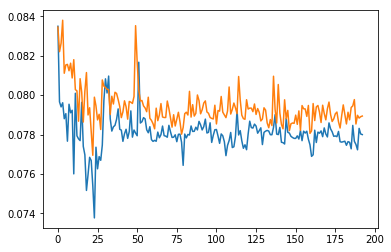

아느                                                     ᄋ----------------ᆻ다.<eos>
아느 ᄋᆻ다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


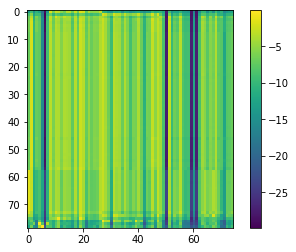

아느                                             ᄋ------------------ᆻ다.<eos>
아느 ᄋᆻ다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


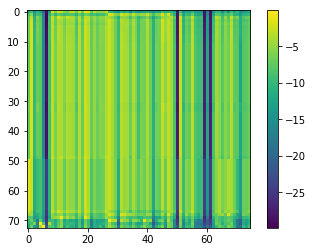

-------------------------------------------------------------------------------------------------------
09-13 05:57:53
Mean Train Loss: 0.07811551752599624
Mean Evaluation Loss: 0.07944260074361863
-------------------------------------------------------------------------------------------------------
09-13 05:58:14
Mean Train Loss: 0.07801546105885362
Mean Evaluation Loss: 0.07850731130499256
-------------------------------------------------------------------------------------------------------
09-13 05:58:35
Mean Train Loss: 0.07782314812594153
Mean Evaluation Loss: 0.07880251563190861
-------------------------------------------------------------------------------------------------------
09-13 05:58:57
Mean Train Loss: 0.07782765144981776
Mean Evaluation Loss: 0.07930802343569329
-------------------------------------------------------------------------------------------------------
09-13 05:59:18
Mean Train Loss: 0.078254489631624
Mean Evaluation Loss: 0.07938391065876095
------------

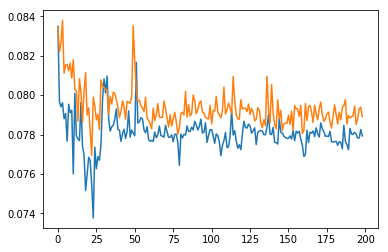

아는                                                      ᄋ--------------------이다.<eos>
아는 ᄋ이다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


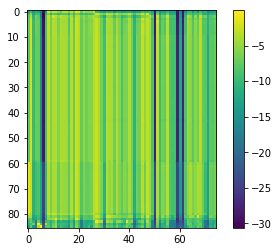

아는                                        ᄋ---------------------이다.<eos>
아는 ᄋ이다.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


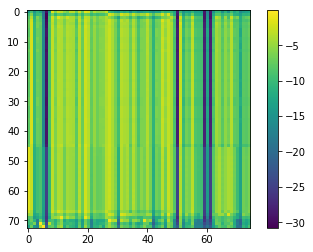

-------------------------------------------------------------------------------------------------------
09-13 06:00:01
Mean Train Loss: 0.07780185288984409
Mean Evaluation Loss: 0.07903318242122201
-------------------------------------------------------------------------------------------------------
09-13 06:00:22
Mean Train Loss: 0.0779753529136118
Mean Evaluation Loss: 0.07866863919330999
-------------------------------------------------------------------------------------------------------
09-13 06:00:43
Mean Train Loss: 0.07778595182070154
Mean Evaluation Loss: 0.07922125656269653
-------------------------------------------------------------------------------------------------------
09-13 06:01:04
Mean Train Loss: 0.07795792703749889
Mean Evaluation Loss: 0.07859233224704625
-------------------------------------------------------------------------------------------------------
09-13 06:01:25
Mean Train Loss: 0.07769494972842197
Mean Evaluation Loss: 0.079817700821064
-------------

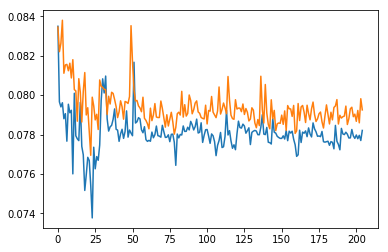

으느                                                               -------------ᄋᆻ다.<eos>
으느 ᄋᆻ다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


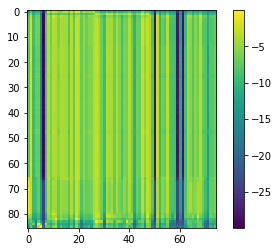

으느                                             ᄋ-----------------ᄂᆻ다.<eos>
으느 ᄋᄂᆻ다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


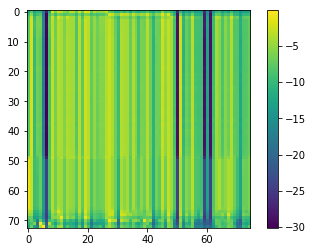

-------------------------------------------------------------------------------------------------------
09-13 06:02:08
Mean Train Loss: 0.07794749386775625
Mean Evaluation Loss: 0.07948393799336526
-------------------------------------------------------------------------------------------------------
09-13 06:02:29
Mean Train Loss: 0.07817993735573936
Mean Evaluation Loss: 0.0794022702262091
-------------------------------------------------------------------------------------------------------
09-13 06:02:50
Mean Train Loss: 0.07830803281091024
Mean Evaluation Loss: 0.07956895330630763
-------------------------------------------------------------------------------------------------------
09-13 06:03:11
Mean Train Loss: 0.0782451449727605
Mean Evaluation Loss: 0.07959893149160682
-------------------------------------------------------------------------------------------------------
09-13 06:03:32
Mean Train Loss: 0.0782834205931449
Mean Evaluation Loss: 0.07919415017746642
-------------

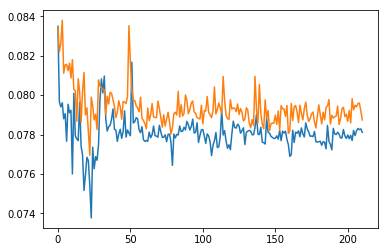

으ᄂ                                                            ᄋ---------이다.<eos>
으ᄂ ᄋ이다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


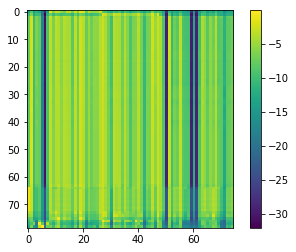

아느                                          ᄋ--------------------이다.<eos>
아느 ᄋ이다.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


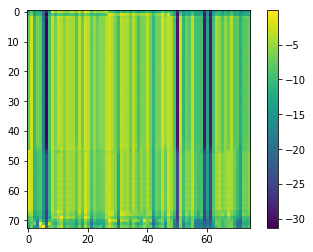

-------------------------------------------------------------------------------------------------------
09-13 06:04:15
Mean Train Loss: 0.0776602148990248
Mean Evaluation Loss: 0.07937793944908979
-------------------------------------------------------------------------------------------------------
09-13 06:04:37
Mean Train Loss: 0.07788960317261294
Mean Evaluation Loss: 0.07976100048199138
-------------------------------------------------------------------------------------------------------
09-13 06:04:58
Mean Train Loss: 0.07825853424615942
Mean Evaluation Loss: 0.07873198077640692
-------------------------------------------------------------------------------------------------------
09-13 06:05:19
Mean Train Loss: 0.07754815821965438
Mean Evaluation Loss: 0.07951277099732118
-------------------------------------------------------------------------------------------------------
09-13 06:05:40
Mean Train Loss: 0.0775958406219607
Mean Evaluation Loss: 0.07847404748017525
------------

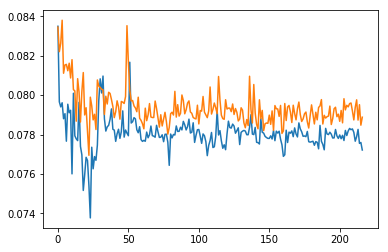

아느                                     ᆫ            ᅡᄋ-----------------------ᆸᄋᆻ다.<eos>
아느 ᆫ ᅡᄋᆸᄋᆻ다.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


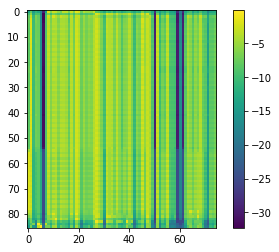

아는 ᆫ ᄋ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫᅡ----------------ᆸᄋᆻ다.<eos>
아는 ᆫ ᄋ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫᅡᆸᄋᆻ다.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


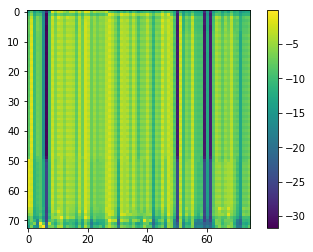

-------------------------------------------------------------------------------------------------------
09-13 06:06:24
Mean Train Loss: 0.07765279613597838
Mean Evaluation Loss: 0.07846402044918485
-------------------------------------------------------------------------------------------------------
09-13 06:06:45
Mean Train Loss: 0.07794468697205763
Mean Evaluation Loss: 0.07925434642039261
-------------------------------------------------------------------------------------------------------
09-13 06:07:06
Mean Train Loss: 0.07787122121694481
Mean Evaluation Loss: 0.07958454916771807
-------------------------------------------------------------------------------------------------------
09-13 06:07:27
Mean Train Loss: 0.07803274575742247
Mean Evaluation Loss: 0.07879298453837376
-------------------------------------------------------------------------------------------------------
09-13 06:07:48
Mean Train Loss: 0.0776362910056052
Mean Evaluation Loss: 0.0788065920970832
------------

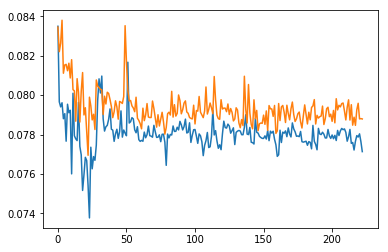

아는ᅳᆫ ᆫ ᆫ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ 아--------------ᆸᄋᆻ다.<eos>
아는ᅳᆫ ᆫ ᆫ ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ 압ᄋᆻ다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


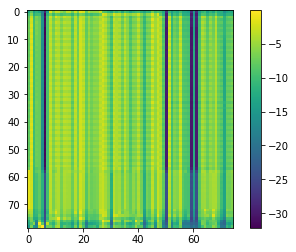

아는 ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ-----------------ᄋ이다.<eos>
아는 ᆫ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ이다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


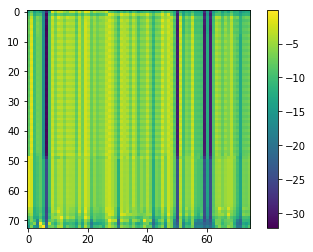

-------------------------------------------------------------------------------------------------------
09-13 06:08:31
Mean Train Loss: 0.0772395236212133
Mean Evaluation Loss: 0.07885442581388649
-------------------------------------------------------------------------------------------------------
09-13 06:08:52
Mean Train Loss: 0.07703635405268533
Mean Evaluation Loss: 0.07899647267089763
-------------------------------------------------------------------------------------------------------
09-13 06:09:13
Mean Train Loss: 0.07708927496970631
Mean Evaluation Loss: 0.07825847550695986
-------------------------------------------------------------------------------------------------------
09-13 06:09:34
Mean Train Loss: 0.07741795268033151
Mean Evaluation Loss: 0.0785663166451508
-------------------------------------------------------------------------------------------------------
09-13 06:09:55
Mean Train Loss: 0.07690622756345379
Mean Evaluation Loss: 0.07866987796314483
------------

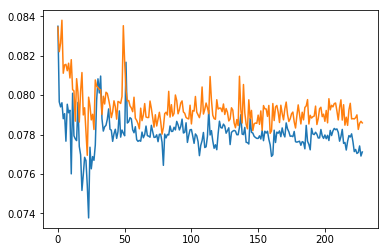

아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ--------------ᄋᄋᆻ다.<eos>
아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋᄋᆻ다.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


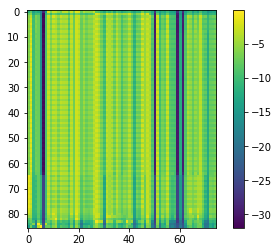

아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ 아----------------ᄋᄋᆻ다.<eos>
아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ 아ᄋᆻ다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


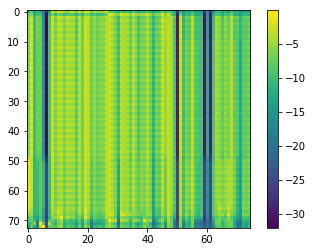

-------------------------------------------------------------------------------------------------------
09-13 06:10:38
Mean Train Loss: 0.07693755124087973
Mean Evaluation Loss: 0.07868304381288453
-------------------------------------------------------------------------------------------------------
09-13 06:10:59
Mean Train Loss: 0.07699576377186058
Mean Evaluation Loss: 0.07836806347301636
-------------------------------------------------------------------------------------------------------
09-13 06:11:20
Mean Train Loss: 0.07685140805517668
Mean Evaluation Loss: 0.07879746859275784
-------------------------------------------------------------------------------------------------------
09-13 06:11:41
Mean Train Loss: 0.0772439402209186
Mean Evaluation Loss: 0.07851775124249587
-------------------------------------------------------------------------------------------------------
09-13 06:12:03
Mean Train Loss: 0.07717356396390095
Mean Evaluation Loss: 0.07851171475277889
-----------

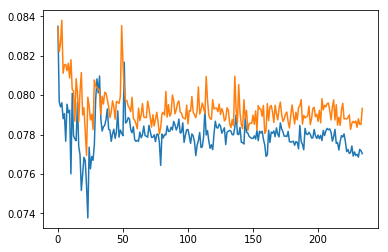

아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆯᅡ아ᄋ--------------------ᆸ이다.<eos>
아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆯᅡ아ᄋᆸ이다.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


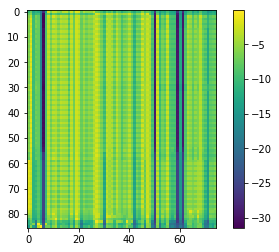

아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ ----------------ᆸ이다.<eos>
아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ ᆸ이다.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


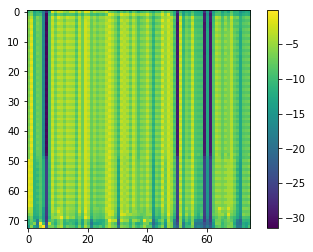

-------------------------------------------------------------------------------------------------------
09-13 06:12:46
Mean Train Loss: 0.07848883820799657
Mean Evaluation Loss: 0.0790166874915882
-------------------------------------------------------------------------------------------------------
09-13 06:13:07
Mean Train Loss: 0.07796568795836048
Mean Evaluation Loss: 0.07938573066141909
-------------------------------------------------------------------------------------------------------
09-13 06:13:28
Mean Train Loss: 0.07835684224721451
Mean Evaluation Loss: 0.07844787270153922
-------------------------------------------------------------------------------------------------------
09-13 06:13:49
Mean Train Loss: 0.07766622928680869
Mean Evaluation Loss: 0.07928614582944642
-------------------------------------------------------------------------------------------------------
09-13 06:14:10
Mean Train Loss: 0.0780576215711943
Mean Evaluation Loss: 0.07883590093280565
------------

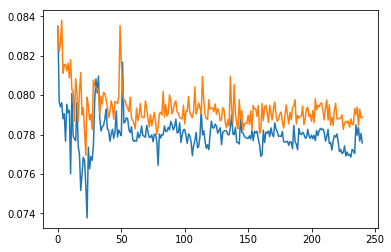

아느                                                   아ᄋ---------------------ᆸᄋᆻ다.<eos>
아느 아ᄋᆸᄋᆻ다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


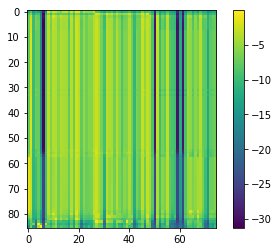

아느                                            아----------------ᆸ이다.<eos>
아느 압이다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


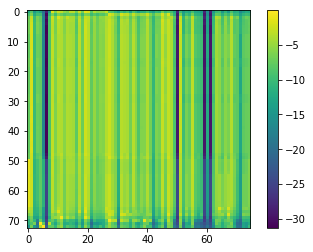

-------------------------------------------------------------------------------------------------------
09-13 06:14:54
Mean Train Loss: 0.07780676513210638
Mean Evaluation Loss: 0.07860858507329747
-------------------------------------------------------------------------------------------------------
09-13 06:15:15
Mean Train Loss: 0.07758929262501987
Mean Evaluation Loss: 0.07871237625999873
-------------------------------------------------------------------------------------------------------
09-13 06:15:36
Mean Train Loss: 0.07751951267487817
Mean Evaluation Loss: 0.07907874101477483
-------------------------------------------------------------------------------------------------------
09-13 06:15:57
Mean Train Loss: 0.07765853867337139
Mean Evaluation Loss: 0.07871966411356605
-------------------------------------------------------------------------------------------------------
09-13 06:16:18
Mean Train Loss: 0.07756882126999173
Mean Evaluation Loss: 0.07869274717171278
----------

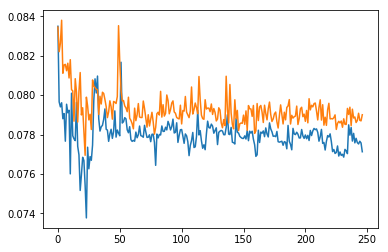

아는 ᆫ ᆫ                                                 ᅡ-------------ᆸᄋᆻ다.<eos>
아는 ᆫ ᆫ ᅡᆸᄋᆻ다.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


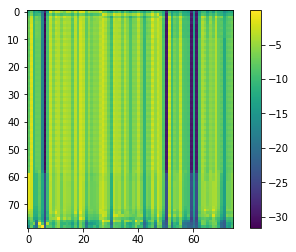

아는 ᆫ ᆫ       ᆫ ᆫ     ᆫ     ᆫ   ᆫ ᆫ         ᄋ       아----------ᆸᄋᆻ다.<eos>
아는 ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᆫ ᄋ 압ᄋᆻ다.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


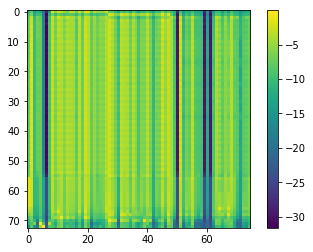

-------------------------------------------------------------------------------------------------------
09-13 06:17:01
Mean Train Loss: 0.07744753188755557
Mean Evaluation Loss: 0.07808704905837437
-------------------------------------------------------------------------------------------------------
09-13 06:17:22
Mean Train Loss: 0.07718547693037485
Mean Evaluation Loss: 0.07814205539491387
-------------------------------------------------------------------------------------------------------
09-13 06:17:43
Mean Train Loss: 0.07706393220303567
Mean Evaluation Loss: 0.07819595446000387
-------------------------------------------------------------------------------------------------------
09-13 06:18:04
Mean Train Loss: 0.07760594943304823
Mean Evaluation Loss: 0.07846259077972663
-------------------------------------------------------------------------------------------------------
09-13 06:18:25
Mean Train Loss: 0.0775003445103548
Mean Evaluation Loss: 0.07924794857224099
-----------

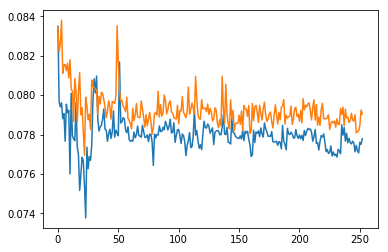

아는                                                    아--------------------ᆸ이다.<eos>
아는 압이다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


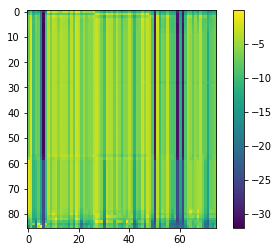

아는                                         아------------------ᆸ이다.<eos>
아는 압이다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


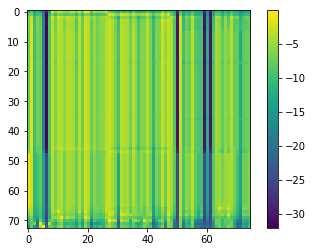

-------------------------------------------------------------------------------------------------------
09-13 06:19:08
Mean Train Loss: 0.07763516239593624
Mean Evaluation Loss: 0.07893351562734953
-------------------------------------------------------------------------------------------------------
09-13 06:19:30
Mean Train Loss: 0.07793449018278026
Mean Evaluation Loss: 0.07883910455273552
-------------------------------------------------------------------------------------------------------
09-13 06:19:51
Mean Train Loss: 0.07776097787397024
Mean Evaluation Loss: 0.07951492627415685
-------------------------------------------------------------------------------------------------------
09-13 06:20:12
Mean Train Loss: 0.07781473599005513
Mean Evaluation Loss: 0.07887078519614217
-------------------------------------------------------------------------------------------------------
09-13 06:20:33
Mean Train Loss: 0.07750160721290456
Mean Evaluation Loss: 0.07890768866525415
----------

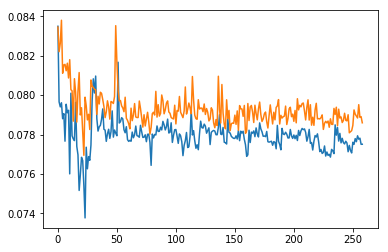

아느ᅳ                                                     아    ---------------ᆸ이다.<eos>
아느 아 ᆸ이다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


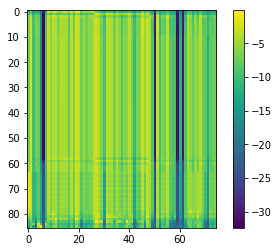

아느ᅳ                                           아----------------ᆸ이다.<eos>
아느 압이다.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


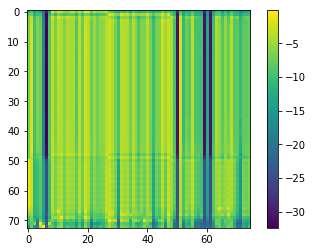

-------------------------------------------------------------------------------------------------------
09-13 06:21:17
Mean Train Loss: 0.07783859697230831
Mean Evaluation Loss: 0.078558729571384
-------------------------------------------------------------------------------------------------------
09-13 06:21:38
Mean Train Loss: 0.07773872266558811
Mean Evaluation Loss: 0.07921164610272884
-------------------------------------------------------------------------------------------------------
09-13 06:21:59
Mean Train Loss: 0.07774777916882522
Mean Evaluation Loss: 0.08043211890403729
-------------------------------------------------------------------------------------------------------
09-13 06:22:20
Mean Train Loss: 0.08037338815180337
Mean Evaluation Loss: 0.07860469683626745
-------------------------------------------------------------------------------------------------------
09-13 06:22:41
Mean Train Loss: 0.0775095618896979
Mean Evaluation Loss: 0.07885826184162602
-------------

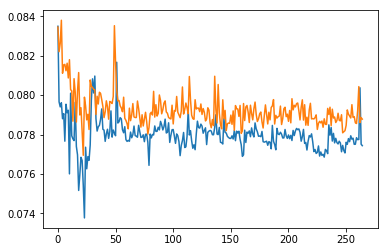

아느ᅳ                                                             아------------ᄋᆻ다.<eos>
아느 아ᄋᆻ다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


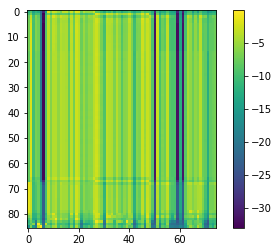

아느                                          알  ---------------ᆸᄋᆻ다.<eos>
아느 알 ᆸᄋᆻ다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


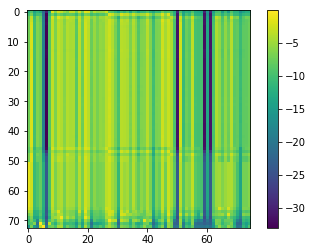

-------------------------------------------------------------------------------------------------------
09-13 06:23:24
Mean Train Loss: 0.07750124124859202
Mean Evaluation Loss: 0.07843184672514861
-------------------------------------------------------------------------------------------------------
09-13 06:23:45
Mean Train Loss: 0.07727832820646333
Mean Evaluation Loss: 0.07831687506969542
-------------------------------------------------------------------------------------------------------
09-13 06:24:06
Mean Train Loss: 0.07740529112669543
Mean Evaluation Loss: 0.07868361668913385
-------------------------------------------------------------------------------------------------------
09-13 06:24:27
Mean Train Loss: 0.07702731015341299
Mean Evaluation Loss: 0.07937178462377115
-------------------------------------------------------------------------------------------------------
09-13 06:24:48
Mean Train Loss: 0.07759653786833778
Mean Evaluation Loss: 0.07902365117333103
----------

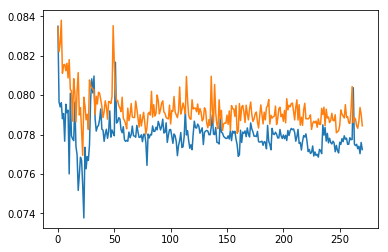

아는  --                                                아-------------ᆸᄋᆻ다.<eos>
아는  압ᄋᆻ다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


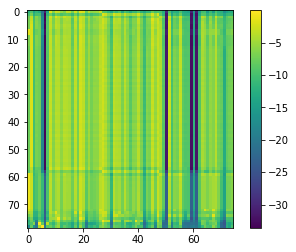

아는                                               아------------ᆸᄋᆻ다.<eos>
아는 압ᄋᆻ다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


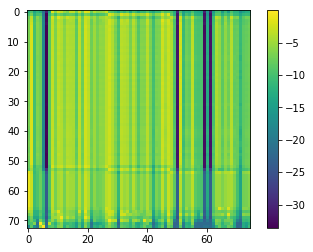

-------------------------------------------------------------------------------------------------------
09-13 06:25:31
Mean Train Loss: 0.07708309200776269
Mean Evaluation Loss: 0.0791575663858673
-------------------------------------------------------------------------------------------------------
09-13 06:25:52
Mean Train Loss: 0.07751490122118507
Mean Evaluation Loss: 0.07910576508812411
-------------------------------------------------------------------------------------------------------
09-13 06:26:13
Mean Train Loss: 0.07719197930128702
Mean Evaluation Loss: 0.07860994963552081
-------------------------------------------------------------------------------------------------------
09-13 06:26:34
Mean Train Loss: 0.07780391436193732
Mean Evaluation Loss: 0.07990346892943825
-------------------------------------------------------------------------------------------------------
09-13 06:26:56
Mean Train Loss: 0.0776087557216933
Mean Evaluation Loss: 0.07898461175846835
------------

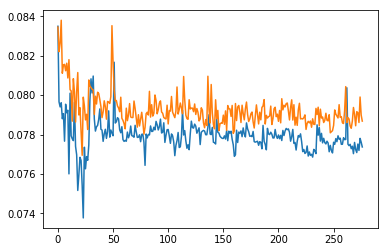

아는ᆫ                                 ᆫᆫ                         알---ᆸᄋᆻ다.<eos>
아는 ᆫ 알ᆸᄋᆻ다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


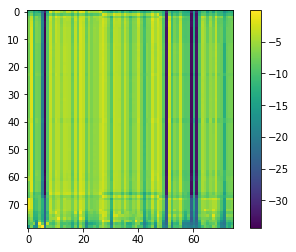

아는        ᆫ                                 을  --------------ᆸᄋᆻ다.<eos>
아는 ᆫ 을 ᆸᄋᆻ다.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


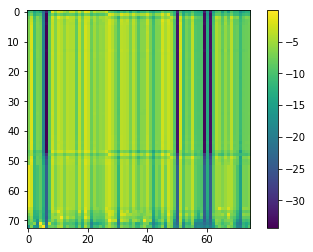

-------------------------------------------------------------------------------------------------------
09-13 06:27:39
Mean Train Loss: 0.07719803644377755
Mean Evaluation Loss: 0.07846727067788906
-------------------------------------------------------------------------------------------------------
09-13 06:28:00
Mean Train Loss: 0.0769679794469285
Mean Evaluation Loss: 0.0786963902538419
-------------------------------------------------------------------------------------------------------
09-13 06:28:21
Mean Train Loss: 0.07729361135622885
Mean Evaluation Loss: 0.0790543368546676
-------------------------------------------------------------------------------------------------------
09-13 06:28:43
Mean Train Loss: 0.07758933739784821
Mean Evaluation Loss: 0.07919173518099594
-------------------------------------------------------------------------------------------------------
09-13 06:29:04
Mean Train Loss: 0.07772721365871599
Mean Evaluation Loss: 0.07904559849330645
-------------

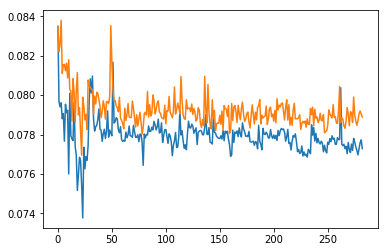

아는                                                 아    ------------ᆸ이다.<eos>
아는 아 ᆸ이다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


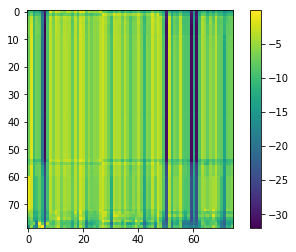

아는                                       아  ------------------ᆸ이다.<eos>
아는 아 ᆸ이다.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


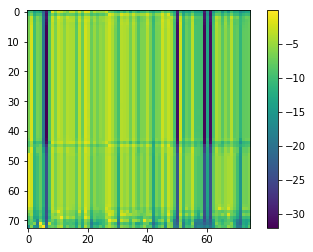

-------------------------------------------------------------------------------------------------------
09-13 06:29:47
Mean Train Loss: 0.0773854092642013
Mean Evaluation Loss: 0.07851384751874539
-------------------------------------------------------------------------------------------------------
09-13 06:30:08
Mean Train Loss: 0.07726127829569134
Mean Evaluation Loss: 0.07827485352366459
-------------------------------------------------------------------------------------------------------
09-13 06:30:29
Mean Train Loss: 0.07718479257668293
Mean Evaluation Loss: 0.07784879228806664
-------------------------------------------------------------------------------------------------------
09-13 06:30:50
Mean Train Loss: 0.07711912432018671
Mean Evaluation Loss: 0.07871421763538294
-------------------------------------------------------------------------------------------------------
09-13 06:31:11
Mean Train Loss: 0.07722934592903133
Mean Evaluation Loss: 0.07797783451512463
-----------

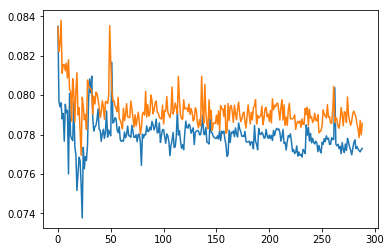

아는 ---                                                        아-----ᄋ이다.<eos>
아는  아이다.<eos>
몇몇 비양심적인 공무원들이 자신들의 지위를 이용해 뇌물을 받았음이 드러났다.<eos>----------


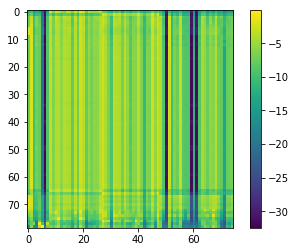

아는  ᄋ--                                              아--------ᆸ이다.<eos>
아는 ᄋ 압이다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


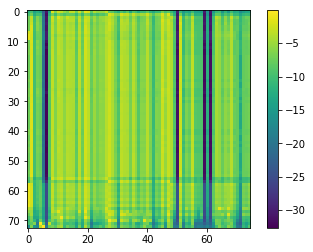

-------------------------------------------------------------------------------------------------------
09-13 06:31:54
Mean Train Loss: 0.07689531959254643
Mean Evaluation Loss: 0.07809771162226781
-------------------------------------------------------------------------------------------------------
09-13 06:32:15
Mean Train Loss: 0.07695499226527215
Mean Evaluation Loss: 0.07892333945777429
-------------------------------------------------------------------------------------------------------
09-13 06:32:36
Mean Train Loss: 0.07740777348461132
Mean Evaluation Loss: 0.07823513443060372
-------------------------------------------------------------------------------------------------------
09-13 06:32:56
Mean Train Loss: 0.07706929855220138
Mean Evaluation Loss: 0.07854724950069542
-------------------------------------------------------------------------------------------------------
09-13 06:33:18
Mean Train Loss: 0.0770701974176186
Mean Evaluation Loss: 0.0781035767527616
------------

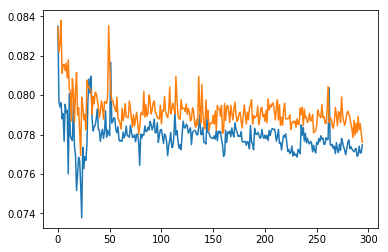

아는                                    ᆫᆫ                 ᆫᆫᆫ     알 인아.<eos>
아는 ᆫ ᆫ 알 인아.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


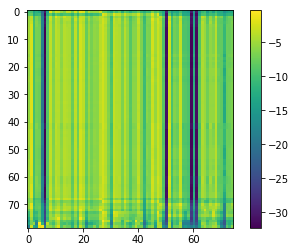

아는                                        알아----------------ᄋᄋᆻ다.<eos>
아는 알아ᄋᆻ다.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


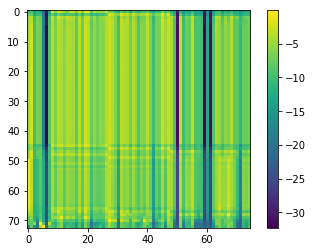

-------------------------------------------------------------------------------------------------------
09-13 06:34:01
Mean Train Loss: 0.07702216988927567
Mean Evaluation Loss: 0.07858063898120322
-------------------------------------------------------------------------------------------------------
09-13 06:34:22
Mean Train Loss: 0.07685602741768902
Mean Evaluation Loss: 0.07802465563514278
-------------------------------------------------------------------------------------------------------
09-13 06:34:43
Mean Train Loss: 0.0764946479823135
Mean Evaluation Loss: 0.07834239238039317
-------------------------------------------------------------------------------------------------------
09-13 06:35:05
Mean Train Loss: 0.07736468970711882
Mean Evaluation Loss: 0.0787479965360242
-------------------------------------------------------------------------------------------------------
09-13 06:35:26
Mean Train Loss: 0.07695146669857542
Mean Evaluation Loss: 0.07853519785117877
------------

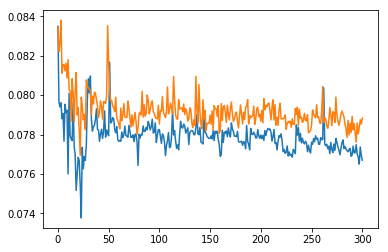

아느ᅡ으ᅳ    ᅡᄋ    ᅡᄋ                           ᅡ   ᄋ ᅡ알아   ᄋ---------ᆸᄋᆻ다.<eos>
아느ᅡ으 ᅡᄋ ᅡᄋ ᅡ ᄋ ᅡ알아 ᄋᆸᄋᆻ다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


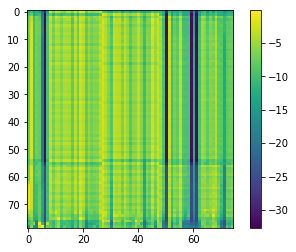

안ᅳᅡ으 으 으 으      으   ᄋ ᄋ  으 ᄋ  으 으 ᄋ   알---------------ᆸᄋᆻ다.<eos>
안ᅳᅡ으 으 으 으 으 ᄋ ᄋ 으 ᄋ 으 으 ᄋ 알ᆸᄋᆻ다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


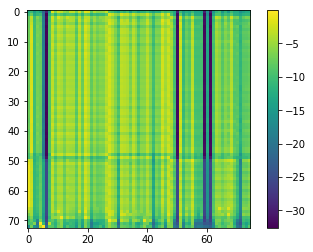

-------------------------------------------------------------------------------------------------------
09-13 06:36:09
Mean Train Loss: 0.07744547350433585
Mean Evaluation Loss: 0.07838801808879493
-------------------------------------------------------------------------------------------------------
09-13 06:36:30
Mean Train Loss: 0.07692378608185027
Mean Evaluation Loss: 0.07778664366255827
-------------------------------------------------------------------------------------------------------
09-13 06:36:51
Mean Train Loss: 0.07654978648256623
Mean Evaluation Loss: 0.07884587864977177
-------------------------------------------------------------------------------------------------------
09-13 06:37:12
Mean Train Loss: 0.07670436275037236
Mean Evaluation Loss: 0.07791069143795354
-------------------------------------------------------------------------------------------------------
09-13 06:37:33
Mean Train Loss: 0.07701159207975698
Mean Evaluation Loss: 0.07812884697062693
----------

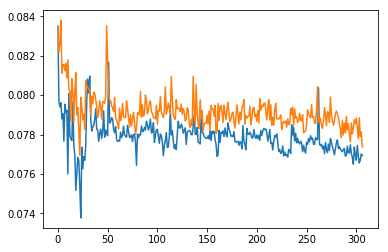

아는 ᆫ   -                                              으 ᄋ ᄋ----------------ᆸᄋᆻ다.<eos>
아는 ᆫ  으 ᄋ ᄋᆸᄋᆻ다.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


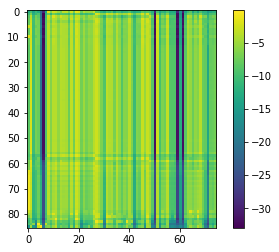

아는                                       안-------------------ᆸ이다.<eos>
아는 안ᆸ이다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


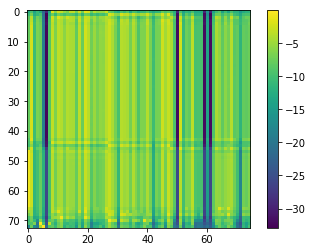

-------------------------------------------------------------------------------------------------------
09-13 06:38:16
Mean Train Loss: 0.07664492769306748
Mean Evaluation Loss: 0.07730624666752778
-------------------------------------------------------------------------------------------------------
09-13 06:38:37
Mean Train Loss: 0.07639651733901802
Mean Evaluation Loss: 0.07737348795656915
-------------------------------------------------------------------------------------------------------
09-13 06:38:58
Mean Train Loss: 0.07629374518226607
Mean Evaluation Loss: 0.07769981005134308
-------------------------------------------------------------------------------------------------------
09-13 06:39:19
Mean Train Loss: 0.07649631049617897
Mean Evaluation Loss: 0.07720512033936645
-------------------------------------------------------------------------------------------------------
09-13 06:39:40
Mean Train Loss: 0.07634340910502936
Mean Evaluation Loss: 0.07692256259270826
----------

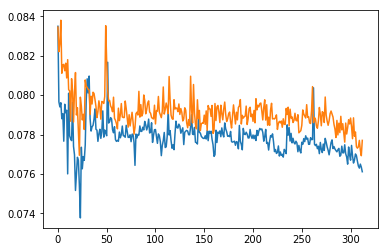

아는 ---                                                      알ᄋ   ------ᄋ--ᆸ이다.<eos>
아는  알ᄋ ᄋᆸ이다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


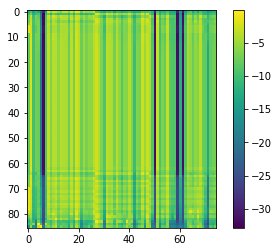

아는                                   ᆫ 안---------------------ᆸ이다.<eos>
아는 ᆫ 안ᆸ이다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


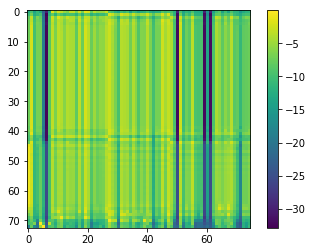

-------------------------------------------------------------------------------------------------------
09-13 06:40:23
Mean Train Loss: 0.07661140336450155
Mean Evaluation Loss: 0.07677897131234042
-------------------------------------------------------------------------------------------------------
09-13 06:40:44
Mean Train Loss: 0.07620608604536842
Mean Evaluation Loss: 0.0763259409775451
-------------------------------------------------------------------------------------------------------
09-13 06:41:05
Mean Train Loss: 0.0761109809917336
Mean Evaluation Loss: 0.07684655946977882
-------------------------------------------------------------------------------------------------------
09-13 06:41:26
Mean Train Loss: 0.07617062992352674
Mean Evaluation Loss: 0.07707069303602553
-------------------------------------------------------------------------------------------------------
09-13 06:41:47
Mean Train Loss: 0.0761220895161673
Mean Evaluation Loss: 0.07670505980631057
-------------

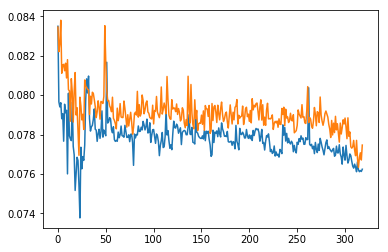

아는                                                              알---------ᆸ이다.<eos>
아는 알ᆸ이다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


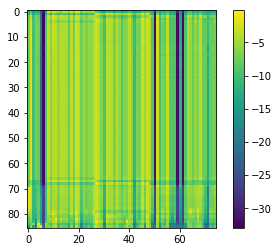

아는--                                          알--------------ᆸ이다.<eos>
아는 알ᆸ이다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


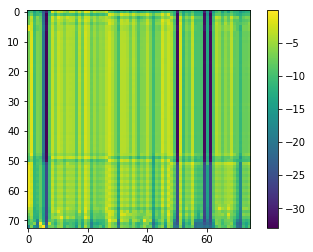

-------------------------------------------------------------------------------------------------------
09-13 06:42:30
Mean Train Loss: 0.0766735799879955
Mean Evaluation Loss: 0.07768065154047583
-------------------------------------------------------------------------------------------------------
09-13 06:42:51
Mean Train Loss: 0.07672092409619463
Mean Evaluation Loss: 0.07684817707782902
-------------------------------------------------------------------------------------------------------
09-13 06:43:12
Mean Train Loss: 0.07610993333997079
Mean Evaluation Loss: 0.07630423431567006
-------------------------------------------------------------------------------------------------------
09-13 06:43:34
Mean Train Loss: 0.07590219382506826
Mean Evaluation Loss: 0.07849131588415309
-------------------------------------------------------------------------------------------------------
09-13 06:43:55
Mean Train Loss: 0.0767411305459673
Mean Evaluation Loss: 0.0775380392277813
-------------

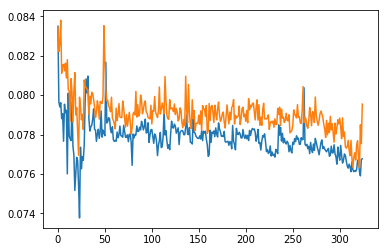

아는ᆫᅡᅡᄋ  ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ  ᄋᄋ  ᄋᄋ    ᄋ ᄋ 아ᅡ ᅡ ᄋ  ᄋ ᄋᄋ ᄋ ᅡ ᄋ ᅡᅡᅡᅡ  ᆫ 갈 ᅡ니다.<eos>
아는ᅡᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ ᄋ 아 ᅡ ᄋ ᄋ ᄋ ᄋ ᅡ ᄋ ᅡ ᆫ 갈 ᅡ니다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


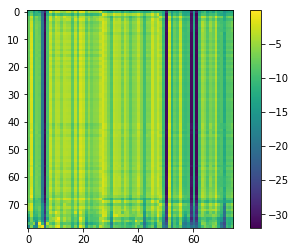

즐ᅳ  ᄋ    ᄋᄋᄋᆫᄋᄋᆫᄋᄋ ᄋᄋᄋᄋᆫᄋᄋᄋᄋ ᄋ  ᄋᄋ ᆫᄋᆫᄋᄋᆫᄋᄋ    ᆫᆫ---------------ᆸᄋᆻ다.<eos>
즐ᅳ ᄋ ᄋᆫᄋᆫᄋ ᄋᆫᄋ ᄋ ᄋ ᆫᄋᆫᄋᆫᄋ ᆫᆸᄋᆻ다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


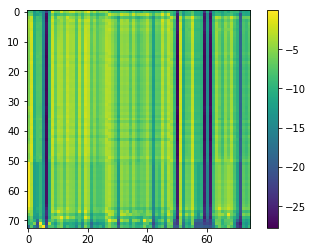

-------------------------------------------------------------------------------------------------------
09-13 06:44:38
Mean Train Loss: 0.07756600913494999
Mean Evaluation Loss: 0.07923658672817056
-------------------------------------------------------------------------------------------------------
09-13 06:44:59
Mean Train Loss: 0.07752378074303506
Mean Evaluation Loss: 0.0770941304613345
-------------------------------------------------------------------------------------------------------
09-13 06:45:20
Mean Train Loss: 0.07673891731522352
Mean Evaluation Loss: 0.07655564975794285
-------------------------------------------------------------------------------------------------------
09-13 06:45:41
Mean Train Loss: 0.07650296981392818
Mean Evaluation Loss: 0.0773120868762411
-------------------------------------------------------------------------------------------------------
09-13 06:46:02
Mean Train Loss: 0.07569567714111768
Mean Evaluation Loss: 0.07638289121432897
------------

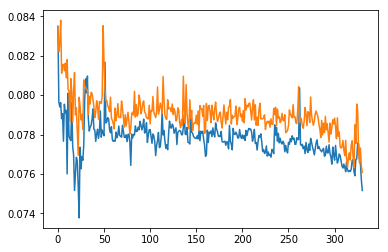

아느ᅡᆫᄋᆫ으 으 으 아 아 ᄋ 으 으 으 아 아 ᄋ 으 아 아 ᄋ  ᄋ 아  알아 아 아 았아.ᄋ
아느ᅡᆫᄋᆫ으 으 으 아 아 ᄋ 으 으 으 아 아 ᄋ 으 아 아 ᄋ ᄋ 아 알아 아 아 았아.ᄋ
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


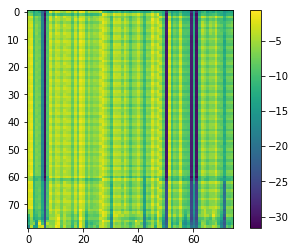

아ᄂ안안아ᄋᄋ 으 안으 아 아 아 아 ᄋ 으 으 으 ᄋ 알----------------이다.<eos>
아ᄂ안안아ᄋ 으 안으 아 아 아 아 ᄋ 으 으 으 ᄋ 알이다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


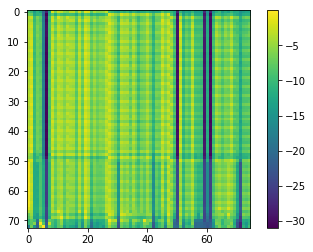

-------------------------------------------------------------------------------------------------------
09-13 06:46:45
Mean Train Loss: 0.07546264110729002
Mean Evaluation Loss: 0.07759983410250264
-------------------------------------------------------------------------------------------------------
09-13 06:47:06
Mean Train Loss: 0.07711004060781036
Mean Evaluation Loss: 0.07862605795491107
-------------------------------------------------------------------------------------------------------
09-13 06:47:27
Mean Train Loss: 0.07717486573935405
Mean Evaluation Loss: 0.07666454996901056
-------------------------------------------------------------------------------------------------------
09-13 06:47:48
Mean Train Loss: 0.07653045126813877
Mean Evaluation Loss: 0.07650360626771975
-------------------------------------------------------------------------------------------------------
09-13 06:48:09
Mean Train Loss: 0.0763186592539375
Mean Evaluation Loss: 0.07630684982437867
-----------

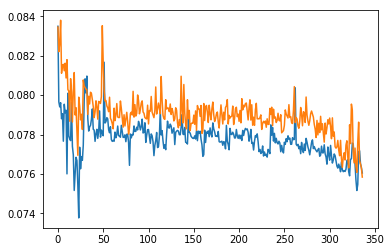

아는ᄋᆫ                                                알아 아 아 아 아 이 이 았다.<eos>
아는ᄋᆫ 알아 아 아 아 아 이 이 았다.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


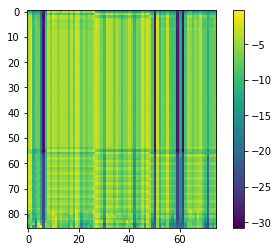

으는ᄋᄋ                                          알ᄋ--------------이아.<eos>
으는ᄋ 알ᄋ이아.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


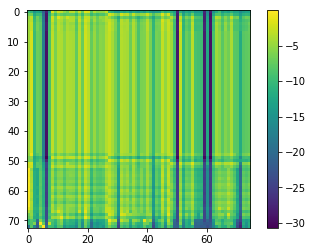

-------------------------------------------------------------------------------------------------------
09-13 06:48:52
Mean Train Loss: 0.07595830031336535
Mean Evaluation Loss: 0.07631338363069744
-------------------------------------------------------------------------------------------------------
09-13 06:49:14
Mean Train Loss: 0.07584870850567864
Mean Evaluation Loss: 0.07552862451034313
-------------------------------------------------------------------------------------------------------
09-13 06:49:34
Mean Train Loss: 0.07558405892014121
Mean Evaluation Loss: 0.07575948760498984
-------------------------------------------------------------------------------------------------------
09-13 06:49:56
Mean Train Loss: 0.0756329647579501
Mean Evaluation Loss: 0.07575349798932829
-------------------------------------------------------------------------------------------------------
09-13 06:50:16
Mean Train Loss: 0.0757928481118483
Mean Evaluation Loss: 0.07630964559517087
------------

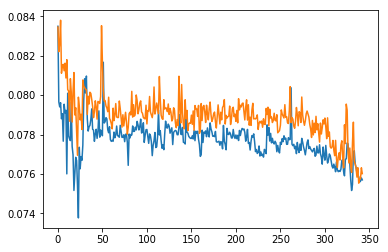

아느ᅡ아ᅳᅡ     으 으  ᅳ 으 으 으 으  ᄋ  ᅳ 으 으 으 으 ᄋ  알아 아 아 아 ᅡᆸᅡᆻ다.<eos>
아느ᅡ아ᅳᅡ 으 으 ᅳ 으 으 으 으 ᄋ ᅳ 으 으 으 으 ᄋ 알아 아 아 아 ᅡᆸᅡᆻ다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


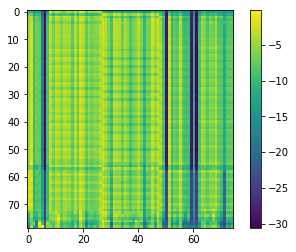

으느ᅡᅳᅡ-ᅳ  ᅡᅡᅡᅡᅡᅡᅡᅡᅡ ᅡᅡᅡ ᅡᅡ ᅡᅡᅡᅡᅡ ᅡ ᅡᅡᅡᅡᅡ ᅡᅡᅡ ᅡ ᅡᅡ ᅡᅡ알----------ᆸ이다.<eos>
으느ᅡᅳᅡᅳ ᅡ ᅡ ᅡ ᅡ ᅡ ᅡ ᅡ ᅡ ᅡ ᅡ알ᆸ이다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


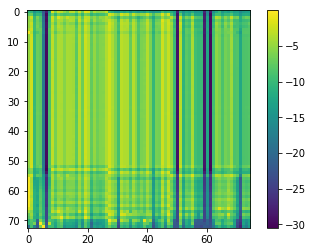

-------------------------------------------------------------------------------------------------------
09-13 06:51:00
Mean Train Loss: 0.07554622400209998
Mean Evaluation Loss: 0.07707155323942681
-------------------------------------------------------------------------------------------------------
09-13 06:51:21
Mean Train Loss: 0.0766373989137102
Mean Evaluation Loss: 0.07683107811642156
-------------------------------------------------------------------------------------------------------
09-13 06:51:42
Mean Train Loss: 0.07596443977054816
Mean Evaluation Loss: 0.07688324547253754
-------------------------------------------------------------------------------------------------------
09-13 06:52:03
Mean Train Loss: 0.07635917946590827
Mean Evaluation Loss: 0.07606699721019591
-------------------------------------------------------------------------------------------------------
09-13 06:52:24
Mean Train Loss: 0.07595274710856079
Mean Evaluation Loss: 0.0762194158574621
------------

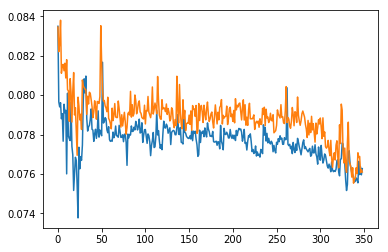

아는                                                   알------ᅡ -  ᅡᅡᆸᄋᆻ다.<eos>
아는 알ᅡ  ᅡᆸᄋᆻ다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


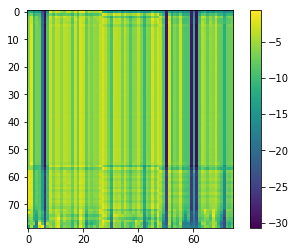

아는ᆫᆫᆫᆫ                                          알 -----------ᆸᄋᆻ다.<eos>
아는 알 ᆸᄋᆻ다.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


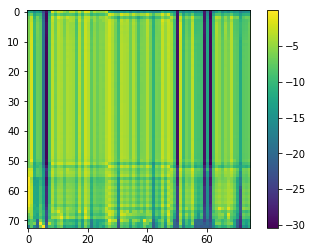

-------------------------------------------------------------------------------------------------------
09-13 06:53:07
Mean Train Loss: 0.07608216496381393
Mean Evaluation Loss: 0.07610730883242868
-------------------------------------------------------------------------------------------------------
09-13 06:53:28
Mean Train Loss: 0.07614237938669681
Mean Evaluation Loss: 0.0761356571857024
-------------------------------------------------------------------------------------------------------
09-13 06:53:49
Mean Train Loss: 0.07596879815034444
Mean Evaluation Loss: 0.07641385164765165
-------------------------------------------------------------------------------------------------------
09-13 06:54:10
Mean Train Loss: 0.07576130163265021
Mean Evaluation Loss: 0.07578168057046893
-------------------------------------------------------------------------------------------------------
09-13 06:54:31
Mean Train Loss: 0.07497789872933451
Mean Evaluation Loss: 0.0754888865081967
------------

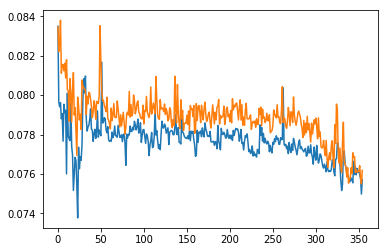

아느 --                                                    알이 -  -         ᅡᆸ이다.<eos>
아느  알이   ᅡᆸ이다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


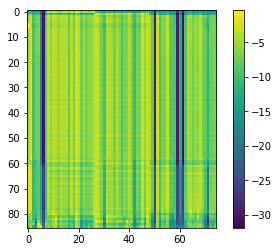

이느 --                                     - 아--------------------ᅵ다.<eos>
이느   아ᅵ다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


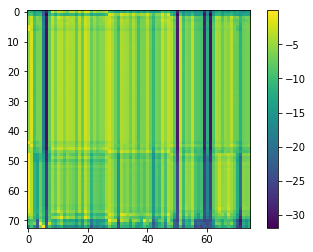

-------------------------------------------------------------------------------------------------------
09-13 06:55:14
Mean Train Loss: 0.07614170675123712
Mean Evaluation Loss: 0.0761736038967577
-------------------------------------------------------------------------------------------------------
09-13 06:55:35
Mean Train Loss: 0.07609963291398045
Mean Evaluation Loss: 0.07580071971104989
-------------------------------------------------------------------------------------------------------
09-13 06:55:56
Mean Train Loss: 0.07564064962783905
Mean Evaluation Loss: 0.07608264498092393
-------------------------------------------------------------------------------------------------------
09-13 06:56:17
Mean Train Loss: 0.07533472326200424
Mean Evaluation Loss: 0.07589776280237759
-------------------------------------------------------------------------------------------------------
09-13 06:56:38
Mean Train Loss: 0.07562839790708098
Mean Evaluation Loss: 0.07807798327779343
-----------

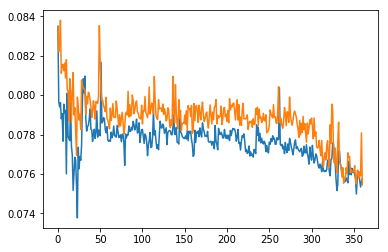

아는-                                                   안아 아 아 아 아 아 ᅡ--ᆻ아.<eos>
아는 안아 아 아 아 아 아 ᅡᆻ아.<eos>
해외로부터 전염병이 유입되어 확산되는 것을 방지하기 위한 노력이 있었다.<eos>-------------------


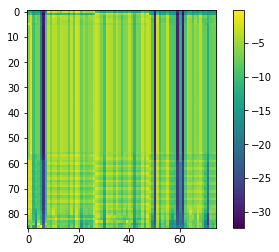

아는ᆫ                                            아---------------ᄋᆻ다.<eos>
아는 아ᄋᆻ다.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


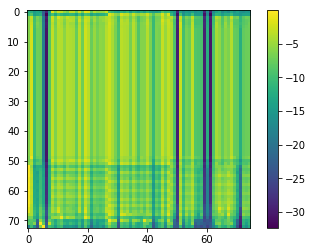

-------------------------------------------------------------------------------------------------------
09-13 06:57:21
Mean Train Loss: 0.07582903391903692
Mean Evaluation Loss: 0.07571016886775064
-------------------------------------------------------------------------------------------------------
09-13 06:57:42
Mean Train Loss: 0.07504415471656291
Mean Evaluation Loss: 0.07538276424189856
-------------------------------------------------------------------------------------------------------
09-13 06:58:03
Mean Train Loss: 0.07521860200142345
Mean Evaluation Loss: 0.07726140782078778
-------------------------------------------------------------------------------------------------------
09-13 06:58:25
Mean Train Loss: 0.07618995115515646
Mean Evaluation Loss: 0.07618177534964457
-------------------------------------------------------------------------------------------------------
09-13 06:58:46
Mean Train Loss: 0.07583841470999975
Mean Evaluation Loss: 0.07624371241808278
----------

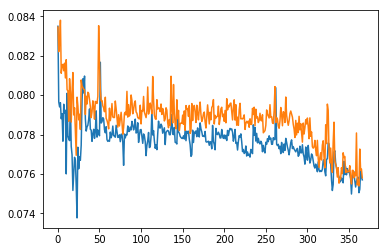

으ᄂ으                   ᄋ   ᄋ                    ᄋ   알아 아 아 아 아 아 아 압ᄋᆻ다.<eos>
으ᄂ으 ᄋ ᄋ ᄋ 알아 아 아 아 아 아 아 압ᄋᆻ다.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


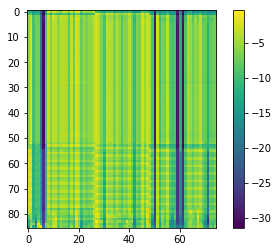

으ᄂ은                                            알-------------ᆸᄋᆻ다.<eos>
으ᄂ은 알ᆸᄋᆻ다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


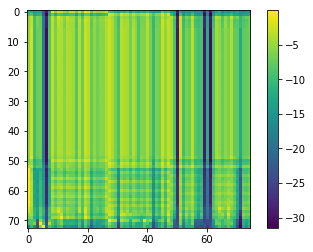

-------------------------------------------------------------------------------------------------------
09-13 06:59:29
Mean Train Loss: 0.07511078199112413
Mean Evaluation Loss: 0.07536678664738539
-------------------------------------------------------------------------------------------------------
09-13 06:59:50
Mean Train Loss: 0.07503321074900048
Mean Evaluation Loss: 0.0771534530379287
-------------------------------------------------------------------------------------------------------
09-13 07:00:12
Mean Train Loss: 0.07607050743535777
Mean Evaluation Loss: 0.07561215445506428
-------------------------------------------------------------------------------------------------------
09-13 07:00:33
Mean Train Loss: 0.07545875985815712
Mean Evaluation Loss: 0.07600175309957351
-------------------------------------------------------------------------------------------------------
09-13 07:00:53
Mean Train Loss: 0.0756410608382823
Mean Evaluation Loss: 0.07582138296115401
------------

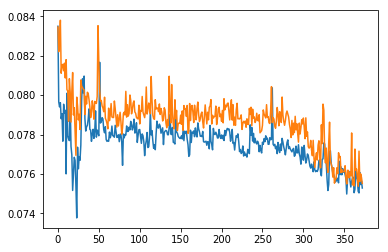

아는-----                                                알아 이 이 아ᄋ이다.<eos>
아는 알아 이 이 아이다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


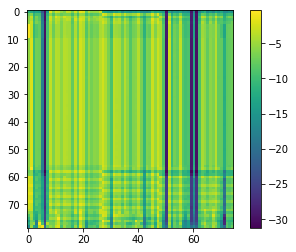

아는---                                        알---------------ᆸ이다.<eos>
아는 알ᆸ이다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


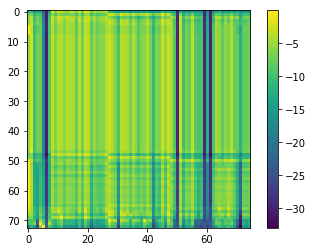

-------------------------------------------------------------------------------------------------------
09-13 07:01:36
Mean Train Loss: 0.07515102821768666
Mean Evaluation Loss: 0.07524974573014694
-------------------------------------------------------------------------------------------------------
09-13 07:01:57
Mean Train Loss: 0.07492289757672523
Mean Evaluation Loss: 0.07592060407648848
-------------------------------------------------------------------------------------------------------
09-13 07:02:18
Mean Train Loss: 0.07525092322610004
Mean Evaluation Loss: 0.07706423952664755
-------------------------------------------------------------------------------------------------------
09-13 07:02:39
Mean Train Loss: 0.07483636512063821
Mean Evaluation Loss: 0.07577282114075706
-------------------------------------------------------------------------------------------------------
09-13 07:03:00
Mean Train Loss: 0.07407402075782551
Mean Evaluation Loss: 0.07530253397070472
----------

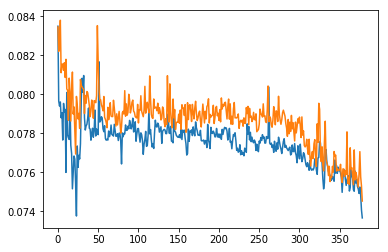

아ᄂ아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 ᅡ 알아-아-아-아-아았아ᄃ<eos>
아ᄂ아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 ᅡ 알아아아아아았아ᄃ<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


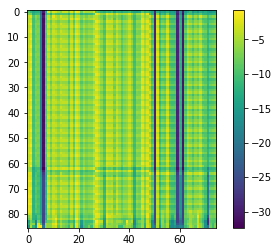

아느ᅡ 아 아 아 아 아 아 아 아 아 아 아 아 아 ᅡ 알-----------------이아.<eos>
아느ᅡ 아 아 아 아 아 아 아 아 아 아 아 아 아 ᅡ 알이아.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


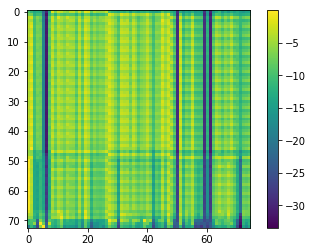

-------------------------------------------------------------------------------------------------------
09-13 07:03:43
Mean Train Loss: 0.07362097779404783
Mean Evaluation Loss: 0.07509341608950924
-------------------------------------------------------------------------------------------------------
09-13 07:04:04
Mean Train Loss: 0.0748383188758324
Mean Evaluation Loss: 0.07554595168475675
-------------------------------------------------------------------------------------------------------
09-13 07:04:25
Mean Train Loss: 0.07442027670368252
Mean Evaluation Loss: 0.07550145704359247
-------------------------------------------------------------------------------------------------------
09-13 07:04:46
Mean Train Loss: 0.07420221806014994
Mean Evaluation Loss: 0.07561142683099203
-------------------------------------------------------------------------------------------------------
09-13 07:05:07
Mean Train Loss: 0.07366573612562392
Mean Evaluation Loss: 0.07499765580578421
-----------

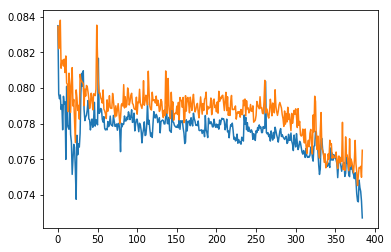

아느                                                       아ᅡᅡ         ᄋ이다.<eos>
아느 아 이다.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


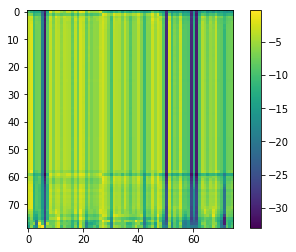

아느                                             나----------------ᄋᆻ다.<eos>
아느 나ᄋᆻ다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


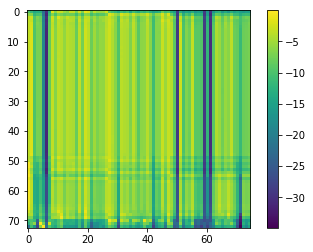

-------------------------------------------------------------------------------------------------------
09-13 07:05:51
Mean Train Loss: 0.0764545287316287
Mean Evaluation Loss: 0.07610246064149141
-------------------------------------------------------------------------------------------------------
09-13 07:06:12
Mean Train Loss: 0.07502363306469467
Mean Evaluation Loss: 0.07541953195013613
-------------------------------------------------------------------------------------------------------
09-13 07:06:33
Mean Train Loss: 0.07286043479457602
Mean Evaluation Loss: 0.0799190266531229
-------------------------------------------------------------------------------------------------------
09-13 07:06:54
Mean Train Loss: 0.07558249958276564
Mean Evaluation Loss: 0.0765504831884261
-------------------------------------------------------------------------------------------------------
09-13 07:07:14
Mean Train Loss: 0.07611804910098986
Mean Evaluation Loss: 0.07628626605692673
-------------

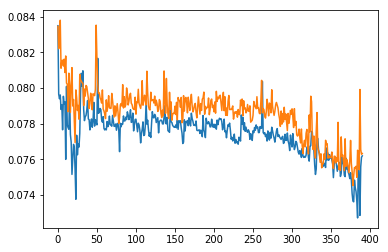

아는ᆫᆫ                                                 알-------------ᄋᄋᆻ다.<eos>
아는 알ᄋᆻ다.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


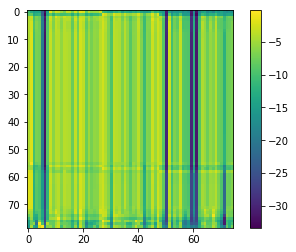

아는ᆫ -                                              아-----------ᄋᆻ다.<eos>
아는  아ᄋᆻ다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


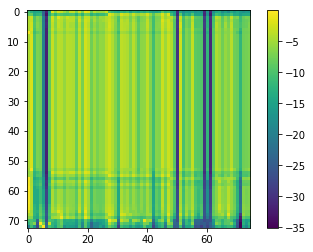

-------------------------------------------------------------------------------------------------------
09-13 07:07:58
Mean Train Loss: 0.07590874271768311
Mean Evaluation Loss: 0.07633350258087962
-------------------------------------------------------------------------------------------------------
09-13 07:08:19
Mean Train Loss: 0.07602253713423844
Mean Evaluation Loss: 0.07609287573528717
-------------------------------------------------------------------------------------------------------
09-13 07:08:40
Mean Train Loss: 0.07589035879102454
Mean Evaluation Loss: 0.07610572604386702
-------------------------------------------------------------------------------------------------------
09-13 07:09:01
Mean Train Loss: 0.0757284708187158
Mean Evaluation Loss: 0.07595038538368655
-------------------------------------------------------------------------------------------------------
09-13 07:09:22
Mean Train Loss: 0.07559749828504009
Mean Evaluation Loss: 0.07582401423941329
-----------

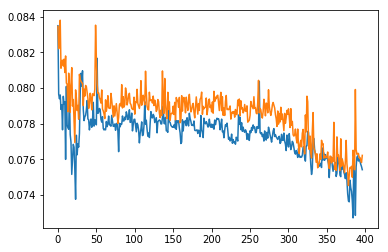

아는                                                         알-------ᄋ이다.<eos>
아는 알이다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


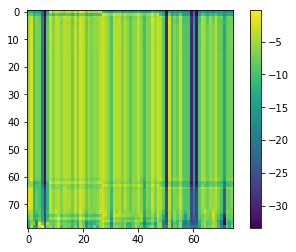

아는---                                             아-----------ᄂ나다.<eos>
아는 아나다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


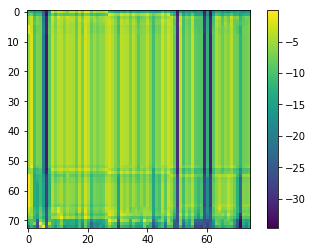

-------------------------------------------------------------------------------------------------------
09-13 07:10:05
Mean Train Loss: 0.07567758695850291
Mean Evaluation Loss: 0.07619748991758767
-------------------------------------------------------------------------------------------------------
09-13 07:10:26
Mean Train Loss: 0.07581827077456138
Mean Evaluation Loss: 0.07570376080472756
-------------------------------------------------------------------------------------------------------
09-13 07:10:47
Mean Train Loss: 0.07541708338141193
Mean Evaluation Loss: 0.07587225445094196
-------------------------------------------------------------------------------------------------------
09-13 07:11:08
Mean Train Loss: 0.07560812547230517
Mean Evaluation Loss: 0.07607124761445483
-------------------------------------------------------------------------------------------------------
09-13 07:11:29
Mean Train Loss: 0.0756503840072505
Mean Evaluation Loss: 0.07587910658489647
-----------

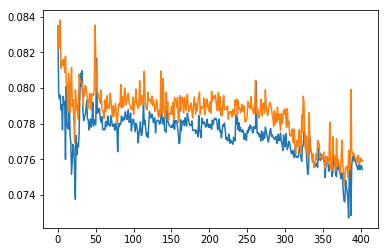

아는ᆫ                                                 알              ᄋᄋᆻ다.<eos>
아는 알 ᄋᆻ다.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


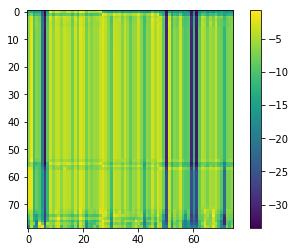

아는ᆫ                                         아-----------------ᄋ이다.<eos>
아는 아이다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


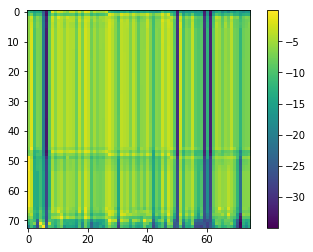

-------------------------------------------------------------------------------------------------------
09-13 07:12:12
Mean Train Loss: 0.07560125976637513
Mean Evaluation Loss: 0.07596371421522509
-------------------------------------------------------------------------------------------------------
09-13 07:12:33
Mean Train Loss: 0.07564812581639514
Mean Evaluation Loss: 0.07585636678392114
-------------------------------------------------------------------------------------------------------
09-13 07:12:54
Mean Train Loss: 0.07540239091662103
Mean Evaluation Loss: 0.07556349043091519
-------------------------------------------------------------------------------------------------------
09-13 07:13:16
Mean Train Loss: 0.07547429236943135
Mean Evaluation Loss: 0.07603875877722663
-------------------------------------------------------------------------------------------------------
09-13 07:13:37
Mean Train Loss: 0.07544267062866453
Mean Evaluation Loss: 0.07555225281578655
----------

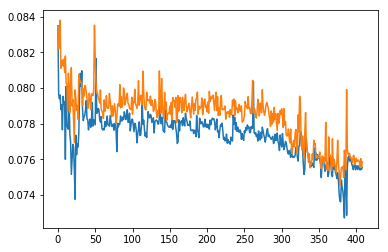

아는--                                                   알             ᅡ----ᆸ니다.<eos>
아는 알 ᅡᆸ니다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


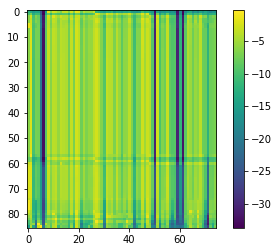

아는                                          알----------------ᆸ이다.<eos>
아는 알ᆸ이다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


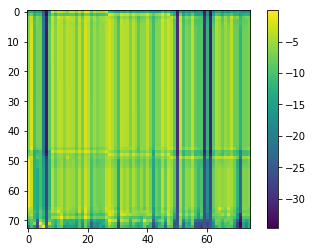

-------------------------------------------------------------------------------------------------------
09-13 07:14:20
Mean Train Loss: 0.07552351759134074
Mean Evaluation Loss: 0.07544422736919776
-------------------------------------------------------------------------------------------------------
09-13 07:14:41
Mean Train Loss: 0.07545795180916319
Mean Evaluation Loss: 0.07545185994042973
-------------------------------------------------------------------------------------------------------
09-13 07:15:03
Mean Train Loss: 0.0753256936962244
Mean Evaluation Loss: 0.07538831716516023
-------------------------------------------------------------------------------------------------------
09-13 07:15:24
Mean Train Loss: 0.07518367986274467
Mean Evaluation Loss: 0.07529275199124215
-------------------------------------------------------------------------------------------------------
09-13 07:15:45
Mean Train Loss: 0.07538576378081586
Mean Evaluation Loss: 0.07575639647885224
-----------

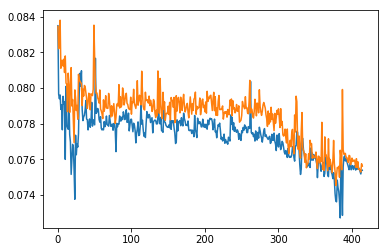

아는                                                 알 ---------------------ᄋᄂᆻ다.<eos>
아는 알 ᄋᄂᆻ다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


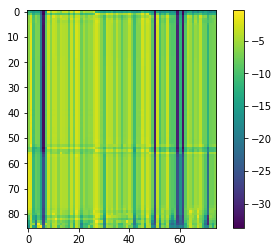

아는ᆫᆫ                                      알------------------ᆸ이아.<eos>
아는 알ᆸ이아.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


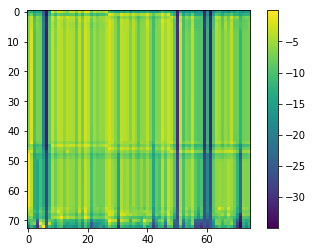

-------------------------------------------------------------------------------------------------------
09-13 07:16:28
Mean Train Loss: 0.0754809056899496
Mean Evaluation Loss: 0.07599458306281266
-------------------------------------------------------------------------------------------------------
09-13 07:16:49
Mean Train Loss: 0.07535818047887072
Mean Evaluation Loss: 0.07605965566359331
-------------------------------------------------------------------------------------------------------
09-13 07:17:10
Mean Train Loss: 0.07564557946196343
Mean Evaluation Loss: 0.07582850769603912
-------------------------------------------------------------------------------------------------------
09-13 07:17:31
Mean Train Loss: 0.07548556396867648
Mean Evaluation Loss: 0.07559970119364844
-------------------------------------------------------------------------------------------------------
09-13 07:17:52
Mean Train Loss: 0.07565126265807348
Mean Evaluation Loss: 0.07567016188061146
-----------

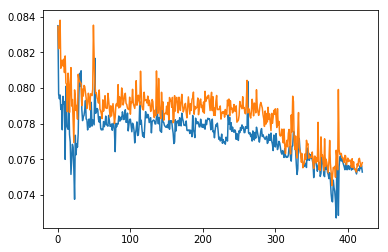

아는                                                  으   ------------------ᄋᄋᄋᆻ다.<eos>
아는 으 ᄋᆻ다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


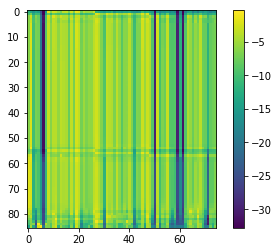

아는--                                      ᅡ 아-----------------ᄋ이다.<eos>
아는 ᅡ 아이다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


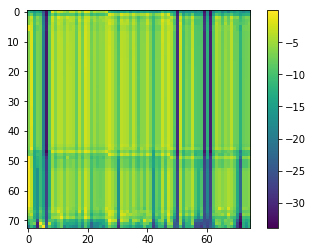

-------------------------------------------------------------------------------------------------------
09-13 07:18:34
Mean Train Loss: 0.0750480073058633
Mean Evaluation Loss: 0.07575818049421662
-------------------------------------------------------------------------------------------------------
09-13 07:18:56
Mean Train Loss: 0.07534038425669033
Mean Evaluation Loss: 0.07569039182230866
-------------------------------------------------------------------------------------------------------
09-13 07:19:17
Mean Train Loss: 0.07526549498423278
Mean Evaluation Loss: 0.07542406335370745
-------------------------------------------------------------------------------------------------------
09-13 07:19:38
Mean Train Loss: 0.07529372137414422
Mean Evaluation Loss: 0.07562685809889201
-------------------------------------------------------------------------------------------------------
09-13 07:19:59
Mean Train Loss: 0.07511878716374115
Mean Evaluation Loss: 0.07531364336076919
-----------

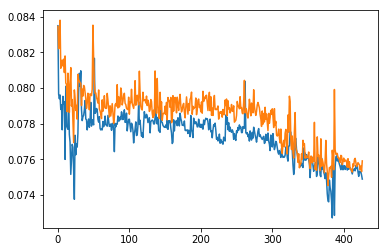

아는---                                                 으  -----------ᆸᄋᆻ다ᅡᅡ
아는 으 ᆸᄋᆻ다
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


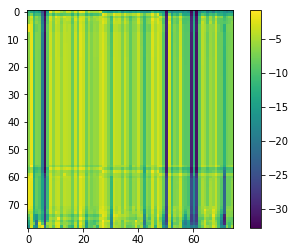

아는-                               -           아----------------이다.<eos>
아는  아이다.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


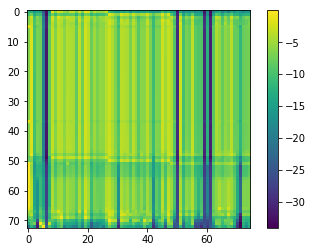

-------------------------------------------------------------------------------------------------------
09-13 07:20:43
Mean Train Loss: 0.0749521597978081
Mean Evaluation Loss: 0.0757551679873631
-------------------------------------------------------------------------------------------------------
09-13 07:21:04
Mean Train Loss: 0.07497903767600089
Mean Evaluation Loss: 0.07667195774799038
-------------------------------------------------------------------------------------------------------
09-13 07:21:25
Mean Train Loss: 0.07513529614064786
Mean Evaluation Loss: 0.07579870235735114
-------------------------------------------------------------------------------------------------------
09-13 07:21:46
Mean Train Loss: 0.07511905182647302
Mean Evaluation Loss: 0.0757871037343016
-------------------------------------------------------------------------------------------------------
09-13 07:22:07
Mean Train Loss: 0.07488877138806914
Mean Evaluation Loss: 0.07586407948032758
-------------

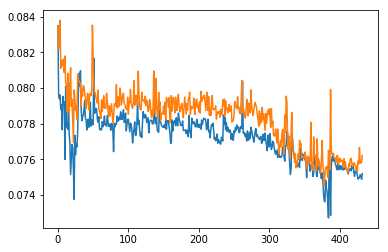

아는ᆫ                                                     알 ---           -ᅡᆸᄋᆻ아.<eos>
아는 알  ᅡᆸᄋᆻ아.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


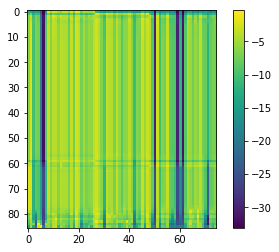

아는                                       ᅡ 아------------------ᆸ이아.<eos>
아는 ᅡ 압이아.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


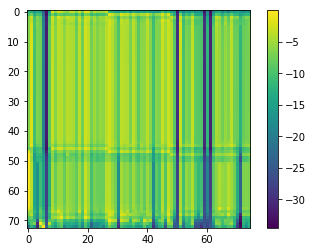

-------------------------------------------------------------------------------------------------------
09-13 07:22:49
Mean Train Loss: 0.07518253161401932
Mean Evaluation Loss: 0.07609885802997275
-------------------------------------------------------------------------------------------------------
09-13 07:23:11
Mean Train Loss: 0.07503173092025853
Mean Evaluation Loss: 0.07567202521928174
-------------------------------------------------------------------------------------------------------
09-13 07:23:32
Mean Train Loss: 0.07488772163530803
Mean Evaluation Loss: 0.07577957494998683
-------------------------------------------------------------------------------------------------------
09-13 07:23:52
Mean Train Loss: 0.07486852303532922
Mean Evaluation Loss: 0.07600239382816674
-------------------------------------------------------------------------------------------------------
09-13 07:24:13
Mean Train Loss: 0.0750377879848684
Mean Evaluation Loss: 0.07570181772554135
-----------

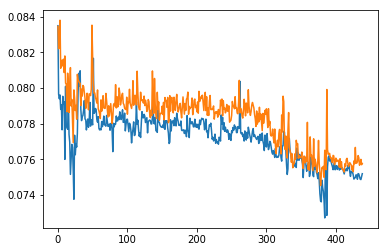

아는                                                         알ᄋ-------------ᄋᄋᆻ다.<eos>
아는 알ᄋᄋᆻ다.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


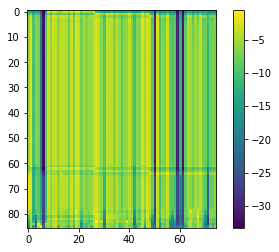

아는----                      --            아-------------------ᆸ이아.<eos>
아는  압이아.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


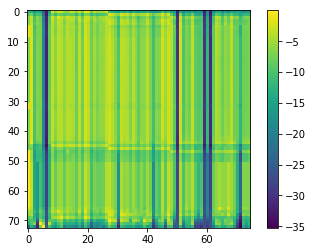

-------------------------------------------------------------------------------------------------------
09-13 07:24:57
Mean Train Loss: 0.07502493165625931
Mean Evaluation Loss: 0.07543667156049125
-------------------------------------------------------------------------------------------------------
09-13 07:25:18
Mean Train Loss: 0.07480938711855098
Mean Evaluation Loss: 0.07575632888902412
-------------------------------------------------------------------------------------------------------
09-13 07:25:39
Mean Train Loss: 0.07485112331374619
Mean Evaluation Loss: 0.07600888085902902
-------------------------------------------------------------------------------------------------------
09-13 07:26:00
Mean Train Loss: 0.07497675471099408
Mean Evaluation Loss: 0.07558087847810757
-------------------------------------------------------------------------------------------------------
09-13 07:26:21
Mean Train Loss: 0.07478580912116403
Mean Evaluation Loss: 0.07577461489671483
----------

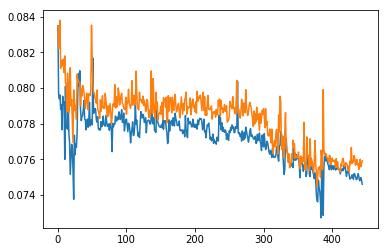

아는  -                                                을ᄋ           -------ᅡᆸ이다.<eos>
아는  을ᄋ ᅡᆸ이다.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


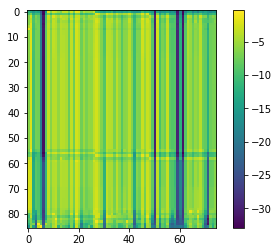

아는-                                    - 아--------------------ᆸ이아.<eos>
아는  압이아.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


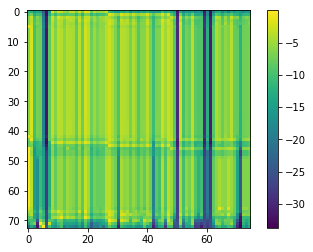

-------------------------------------------------------------------------------------------------------
09-13 07:27:04
Mean Train Loss: 0.07470318685596751
Mean Evaluation Loss: 0.07547656449970216
-------------------------------------------------------------------------------------------------------
09-13 07:27:25
Mean Train Loss: 0.07472246826540557
Mean Evaluation Loss: 0.07538409306248926
-------------------------------------------------------------------------------------------------------
09-13 07:27:46
Mean Train Loss: 0.07488226311838926
Mean Evaluation Loss: 0.0755428163285787
-------------------------------------------------------------------------------------------------------
09-13 07:28:08
Mean Train Loss: 0.07467577275283876
Mean Evaluation Loss: 0.07589948719338627
-------------------------------------------------------------------------------------------------------
09-13 07:28:29
Mean Train Loss: 0.07474017382197244
Mean Evaluation Loss: 0.07589060057752087
-----------

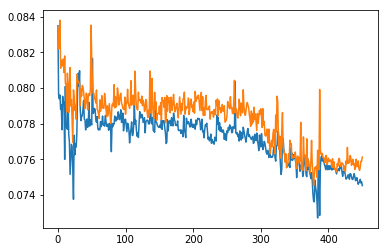

아는ᆫ-                                                   은ᄋ-----------------ᄋᄋᆻ다.<eos>
아는 은ᄋᄋᆻ다.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


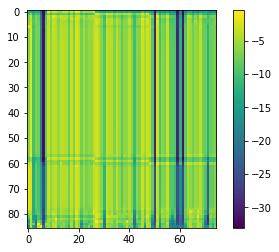

아는ᆫ                                        아------------------ᆸ이아.<eos>
아는 압이아.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


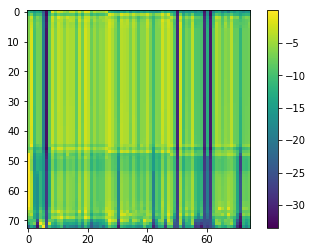

-------------------------------------------------------------------------------------------------------
09-13 07:29:12
Mean Train Loss: 0.07467515468646962
Mean Evaluation Loss: 0.07592268691740857
-------------------------------------------------------------------------------------------------------
09-13 07:29:33
Mean Train Loss: 0.07453132884475958
Mean Evaluation Loss: 0.07656758897428564
-------------------------------------------------------------------------------------------------------
09-13 07:29:54
Mean Train Loss: 0.07463913219033297
Mean Evaluation Loss: 0.07586511365209961
-------------------------------------------------------------------------------------------------------
09-13 07:30:15
Mean Train Loss: 0.07443727812298419
Mean Evaluation Loss: 0.07594854820668548
-------------------------------------------------------------------------------------------------------
09-13 07:30:36
Mean Train Loss: 0.0745429752451577
Mean Evaluation Loss: 0.0761733755555901
------------

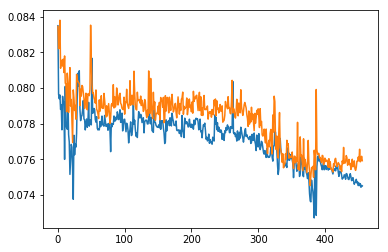

아는-----                                               을아     ᅡ    ᄋᄋᆻ다.<eos>
아는 을아 ᅡ ᄋᆻ다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


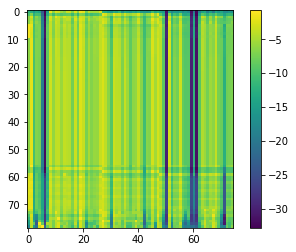

아는-                                      ᄋ 아------------------ᆸᄋᆻ아.<eos>
아는 ᄋ 압ᄋᆻ아.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


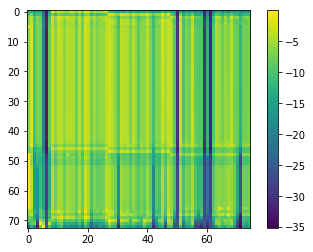

-------------------------------------------------------------------------------------------------------
09-13 07:31:19
Mean Train Loss: 0.07445142811888046
Mean Evaluation Loss: 0.07615050181539057
-------------------------------------------------------------------------------------------------------
09-13 07:31:40
Mean Train Loss: 0.07434831455030134
Mean Evaluation Loss: 0.07553102658073946
-------------------------------------------------------------------------------------------------------
09-13 07:32:01
Mean Train Loss: 0.07417530891150535
Mean Evaluation Loss: 0.07580700673109246
-------------------------------------------------------------------------------------------------------
09-13 07:32:22
Mean Train Loss: 0.07429531798422816
Mean Evaluation Loss: 0.07619371759505268
-------------------------------------------------------------------------------------------------------
09-13 07:32:43
Mean Train Loss: 0.07437811137057664
Mean Evaluation Loss: 0.07570057857512874
----------

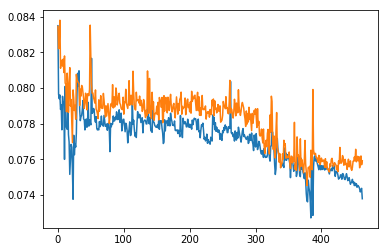

아는----                                               으 ᄋ            ᄋᄋᆻ다.<eos>
아는 으 ᄋ ᄋᆻ다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


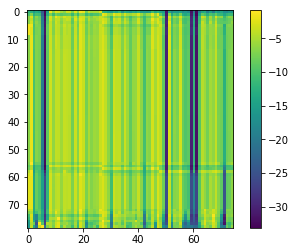

아는---                                     ᄋ 아------------------이다.<eos>
아는 ᄋ 아이다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


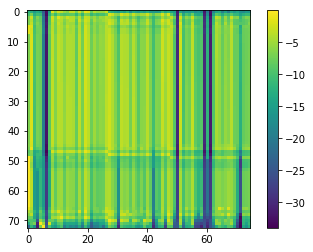

-------------------------------------------------------------------------------------------------------
09-13 07:33:26
Mean Train Loss: 0.07351439083483262
Mean Evaluation Loss: 0.07575648144169132
-------------------------------------------------------------------------------------------------------
09-13 07:33:48
Mean Train Loss: 0.07378072468801453
Mean Evaluation Loss: 0.07581892308350693
-------------------------------------------------------------------------------------------------------
09-13 07:34:09
Mean Train Loss: 0.07358398594068417
Mean Evaluation Loss: 0.07634077305741396
-------------------------------------------------------------------------------------------------------
09-13 07:34:30


KeyboardInterrupt: ignored

In [113]:
EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
# try:
#     net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
# except:
#     print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch()
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_eval.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")